## Library

In [176]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

from copy import copy
from scipy import stats

exec(open('library.py').read())
print('Loaded')

Loaded
Loaded


## Variables (customize these)

In [177]:
# Customize these!!!

# Global variables - probably don't want to change these but you could.
RUNS = 10000                                      # Number of runs to do (default 1000)
CURRENT_YEAR = 2022                               # What year to start the run on? (default: 2022)
MAX_YEAR = 2222                                   # What year to end the run on? (default: 2100)
USE_NUMBERS = 'Peter'                             # Which variable set (see below) to use?
GRAPH_P = 50                                      # What percentile to graph on the graphs below? (default: 50)
initial_gdp = 21 * trillion                       # GDP in `CURRENT_YEAR` of country that will develop TAI (default: 21.3 trillion)


# Variable sets - definitely change these!
if USE_NUMBERS == 'Ajeya':
    CREDIBLE_INTERVAL = 0.9                        # These are 90% CIs
    tai_flop_size = lognorm(27.58, 46.29)          # 90% CI, it takes 10^FLOPs to run a transformative AI at inference. Take 10^13-17 from Carlsmith report and add 1 OOM due to algorithmic inefficiency.
                                                   # Note: A petaflop/s-day (pfs-day) consists of performing 10^15 neural net operations per second for one day, or a total of about 10^20 operations
    algo_doubling_rate = norm(2.5, 2.5)            # 90% CI, algorithms get twice as efficient every X years
    min_reduction = norm(2, 2)                     # 90% CI, the minimum amount of OOMs of reduction in TAI size algorithm improvements could acheive
    max_reduction = norm(5, 5)                     # 90% CI, the maximum amount of OOMs of reduction in TAI size algorithm improvements could acheive
    initial_flops_per_dollar = norm(17.2, 17.2)    # 90% CI, as of today, we can buy 10^X FLOPs per $
    flops_halving_rate = norm(2.6, 3)              # 90% CI, the cost of FLOPs per $ halves every X years
    max_flops_per_dollar = norm(24, 24)            # 90% CI, the cheapest FLOPs will get is 10^X FLOPs per $
    initial_pay = norm(8.7, 8.7)                   # 90% CI, as of today the maximum we would pay for TAI is $10^X
    gdp_growth = norm(1.03, 1.03)                  # 90% CI, GDP will increase by a factor of X each year
    max_gdp_frac = norm(0.01, 0.01)                # 90% CI, the maximum % of GDP that would be spent on TAI is $10^X
    willingness_ramp = norm(1, 1)                  # 90% CI, if we are X% of the spend needed to acheive TAI, we will instantly jump to TAI
    spend_doubling_time = norm(2.5, 2.5)           # 90% CI, our willingness to spend on TAI doubles every X years
    initial_chance_of_nonscaling_issue = 0         # What is the chance there will be a non-scaling issue if TAI is feasible in `CURRENT_YEAR`?
    final_chance_of_nonscaling_issue = 0           # What is the chance there will be a non-scaling issue if TAI is feasible only by `nonscaling_issue_bottom_year` (see below)?
    nonscaling_issue_bottom_year = 0               # What year will will the chance of a non-scaling issue bottom out at (reaching `final_chance_of_nonscaling_issue`)?
    nonscaling_delay = norm(0, 0)                  # 90% CI, conditional on a delay, how many additional years will TAI be delayed due to issues unrelated to scaling to an adequate number of FLOPs (e.g., collecting the relevant training data)?
    base_p_recursive = 0                           # TODO: explain
    recursive_curve_steepness = 0
    recursive_curve_inflection = 0
    p_recursive_creates_tai_instantly = 0
    recursive_flops_halving_rate_ = None
    recursive_algo_doubling_rate_ = None
    recursive_spend_doubling_time = None
    recursive_gdp_growth_ = None
    recursive_initial_chance_of_nonscaling_issue = None
    recursive_final_chance_of_nonscaling_issue = None

elif USE_NUMBERS == 'Peter':
    CREDIBLE_INTERVAL = 0.9
    tai_flop_size = lognorm(26, 46)
    algo_doubling_rate = norm_lclip(1, 5)
    min_reduction = norm(1, 3)                     # 90% CI, the minimum amount of OOMs of reduction in TAI size algorithm improvements could acheive
    max_reduction = norm(4, 8)                     # 90% CI, the maximum amount of OOMs of reduction in TAI size algorithm improvements could acheive
    initial_flops_per_dollar = norm(17, 17.5)      # More increase in compute, plus possibilities that big companies have found some additional initial efficiency.
    flops_halving_rate = norm(2, 4)
    max_flops_per_dollar = norm(24, 26)            # Added uncertainty around fundamental limits
    initial_pay = norm(7, 8)                       # Minimum of $10M since that has already happened. Uncertain of how much we could be paying privately.
    gdp_growth = norm(1.015, 1.03)                 # Added uncertainty around potential GDP slowdown
    max_gdp_frac = lognorm_lclip(0.0015, 0.025)    # Added uncertainty around how much of GDP we'd be willing to spend
    willingness_ramp = norm(0.7, 1)
    spend_doubling_time = lognorm_lclip(0.5, 2)    # Added uncertainty around how fast spending will accelerate
    initial_chance_of_nonscaling_issue = 0.9
    final_chance_of_nonscaling_issue = 0.1
    nonscaling_issue_bottom_year = 2060
    nonscaling_delay = lognorm(1, 20)
    base_p_recursive = 0.5
    recursive_curve_steepness = 35
    recursive_curve_inflection = 0.1
    p_recursive_creates_tai_instantly = 0.05
    recursive_flops_halving_rate = lognorm_lclip(0.3, 2)
    recursive_algo_doubling_rate = lognorm_lclip(0.3, 2)
    recursive_spend_doubling_time = lognorm_lclip(0.3, 2)
    recursive_gdp_growth = lognorm_lclip(1.02, 1.1)
    recursive_initial_chance_of_nonscaling_issue = 0.2
    recursive_final_chance_of_nonscaling_issue = 0.01
    
else:
    raise ValueError


# These equations define how variables change over time or in relationship to other variables.
def gdp(initial_gdp, gdp_growth, year):
    return initial_gdp * (gdp_growth ** year)

def willingness_to_pay(initial_gdp, gdp_growth, initial_pay, spend_doubling_time, max_gdp_frac, year):
    gdp_ = gdp(initial_gdp=initial_gdp, gdp_growth=gdp_growth, year=year)
    x = (np.log(2) / spend_doubling_time) * year
    if x < 709:
        return 10 ** (math.log10(initial_pay) + math.log10(math.exp(x)) - math.log10(1 + initial_pay / (gdp_ * max_gdp_frac) * math.exp(x)))
    else: # Handle math.exp and math.log10 overflow errors
        return 10 ** int(math.log10(initial_pay) + (year/spend_doubling_time)/3.3)

def possible_algo_reduction_fn(min_reduction, max_reduction, tai_flop_size):
    return min(max(min_reduction + round((tai_flop_size - 32) / 4), min_reduction), max_reduction)

def flops_needed(initial_flops, possible_reduction, doubling_rate, year):
    x = (np.log(2) / doubling_rate) * year
    if x < 709:
        return 10 ** (math.log10(initial_flops) - max(math.log10(math.exp(x)) - math.log10(1 + (1/possible_reduction) * math.exp(x)), 0))
    else: # Handle math.exp and math.log10 overflow errors
        return 10 ** int(math.log10(initial_flops) - (1/possible_reduction))

def flops_per_dollar(initial_flops_per_dollar, max_flops_per_dollar, halving_rate, year):
    x = (np.log(2) / halving_rate) * year
    if x < 709:
        return 10 ** (math.log10(initial_flops_per_dollar) + math.log10(math.exp(x)) - math.log10(1 + initial_flops_per_dollar / max_flops_per_dollar * math.exp(x)))
    else: # Handle math.exp and math.log10 overflow errors
        return 10 ** int(math.log10(initial_flops_per_dollar) + (year/halving_rate)/3.3)

def cost_of_tai(initial_flops, possible_reduction, algo_doubling_rate, initial_flops_per_dollar, max_flops_per_dollar,
                flops_halving_rate, year):
    return (flops_needed(initial_flops, possible_reduction, algo_doubling_rate, year) /
            flops_per_dollar(initial_flops_per_dollar, max_flops_per_dollar, flops_halving_rate, year))

def flops_at_max(initial_gdp, gdp_growth, initial_pay, spend_doubling_time, max_gdp_frac,
                 initial_flops_per_dollar, max_flops_per_dollar, flops_halving_rate, year):
    return (willingness_to_pay(initial_gdp=initial_gdp,
                               gdp_growth=gdp_growth,
                               initial_pay=initial_pay,
                               spend_doubling_time=spend_doubling_time,
                               max_gdp_frac=0.01,
                               year=year) *
            flops_per_dollar(initial_flops_per_dollar, max_flops_per_dollar, flops_halving_rate, year))

def p_nonscaling_delay(initial_p, final_p, year, max_year):
    initial_p = initial_p - final_p
    p_ = initial_p - (initial_p * ((year - CURRENT_YEAR) / (max_year - CURRENT_YEAR))) + final_p
    return final_p if p_ < final_p else p_

def p_rapid_recursive_self_improvement(flops_needed_for_tai, flops_we_have, base_p, curve_steepness, curve_inflection):
    if flops_we_have > 10 ** 250:
        return base_p  # Handle overflow error
    else:
        ratio = flops_we_have / flops_needed_for_tai
        return base_p / (1 + math.exp(-curve_steepness * (ratio - curve_inflection)))

    
# ------------- Ignore below here ------------
years = list(range(CURRENT_YEAR, MAX_YEAR))
print('Loaded')


Loaded


In [178]:
initial_flops_p = get_percentiles([sample(tai_flop_size, credibility=CREDIBLE_INTERVAL) for s in range(1000)], reverse=True)
initial_flops_p

{95: 25.97473439026855,
 90: 27.705887073339586,
 80: 29.726652265713117,
 70: 31.39870875338219,
 60: 32.947128143703814,
 50: 34.376033115814074,
 40: 36.09161156641766,
 30: 37.748308580658104,
 20: 40.38695271163854,
 10: 43.506068919716874,
 5: 46.500629512649176}

In [179]:
min_reduction_p = get_percentiles([sample(min_reduction, credibility=CREDIBLE_INTERVAL) for s in range(1000)], reverse=True)
min_reduction_p

{95: 0.9999813465169547,
 90: 1.1989860620013604,
 80: 1.4558866377741837,
 70: 1.6334742444237638,
 60: 1.8048110606897734,
 50: 1.9501136861606376,
 40: 2.1042263681859112,
 30: 2.2889722132704176,
 20: 2.4701760540675157,
 10: 2.7418974394901774,
 5: 2.9460815702204375}

In [180]:
max_reduction_p = get_percentiles([sample(max_reduction, credibility=CREDIBLE_INTERVAL) for s in range(1000)], reverse=True)
max_reduction_p

{95: 3.999297376481116,
 90: 4.493426706262984,
 80: 5.025342697434255,
 70: 5.360908969352277,
 60: 5.662664974306405,
 50: 6.037697097847149,
 40: 6.308654566696135,
 30: 6.616102787985523,
 20: 6.937177362541894,
 10: 7.5554882116286315,
 5: 8.025252010377024}

In [181]:
algo_doubling_rate_p = get_percentiles([sample(algo_doubling_rate, credibility=CREDIBLE_INTERVAL) for s in range(1000)], reverse=True)
algo_doubling_rate_p

{95: 1.0,
 90: 1.3941095627807079,
 80: 1.9154998495107307,
 70: 2.269337686596022,
 60: 2.610500374789268,
 50: 2.974871328257342,
 40: 3.2455781979783644,
 30: 3.569634280627322,
 20: 3.9746588371370293,
 10: 4.591971473631001,
 5: 5.071219589323579}

In [182]:
initial_flops_per_dollar_p = get_percentiles([sample(initial_flops_per_dollar, credibility=CREDIBLE_INTERVAL) for s in range(1000)])
initial_flops_per_dollar_p

{5: 17.002861461891058,
 10: 17.055455804007593,
 20: 17.115946804838735,
 30: 17.167261902443336,
 40: 17.215505393968684,
 50: 17.25899055371584,
 60: 17.293810482198825,
 70: 17.336853083336194,
 80: 17.389765953292454,
 90: 17.447414293848823,
 95: 17.504337433397385}

In [183]:
flops_halving_rate_p = get_percentiles([sample(flops_halving_rate, credibility=CREDIBLE_INTERVAL) for s in range(1000)], reverse=True)
flops_halving_rate_p

{95: 1.9516647896086352,
 90: 2.1627299357222207,
 80: 2.4321429049182646,
 70: 2.645319089955167,
 60: 2.828731084627182,
 50: 2.9899109432133866,
 40: 3.1536308920214906,
 30: 3.292260954702325,
 20: 3.489885464258653,
 10: 3.7783128672804107,
 5: 3.9897224474708914}

In [184]:
max_flops_per_dollar_p = get_percentiles([sample(max_flops_per_dollar, credibility=CREDIBLE_INTERVAL) for s in range(1000)])
max_flops_per_dollar_p

{5: 23.92893971327205,
 10: 24.13794512778946,
 20: 24.478511618193902,
 30: 24.6924263655976,
 40: 24.83382279843137,
 50: 24.991089225434138,
 60: 25.155520450248023,
 70: 25.335473901340944,
 80: 25.51183361269336,
 90: 25.85368313507406,
 95: 26.06740396133949}

In [185]:
initial_pay_p = get_percentiles([sample(initial_pay, credibility=CREDIBLE_INTERVAL) for s in range(1000)])
initial_pay_p

{5: 7.006141367727564,
 10: 7.112173741776638,
 20: 7.242395063580371,
 30: 7.337578055214306,
 40: 7.429766975392758,
 50: 7.505506863836977,
 60: 7.5688816682568225,
 70: 7.6465112051697135,
 80: 7.740969949348729,
 90: 7.873983603534393,
 95: 8.003977954075927}

In [186]:
gdp_growth_p = get_percentiles([sample(gdp_growth, credibility=CREDIBLE_INTERVAL) for s in range(1000)])
gdp_growth_p

{5: 1.0149960465101164,
 10: 1.0166141096465877,
 20: 1.018714366038921,
 30: 1.0199820551193588,
 40: 1.0212436684241828,
 50: 1.0225052102595669,
 60: 1.0236784965357493,
 70: 1.0248568926405877,
 80: 1.026223674558295,
 90: 1.0282956809313681,
 95: 1.0302934655980425}

In [187]:
max_gdp_frac_p = get_percentiles([sample(max_gdp_frac, credibility=CREDIBLE_INTERVAL) for s in range(1000)])
max_gdp_frac_p

{5: 0.0015,
 10: 0.0019980941912731767,
 20: 0.0029559450253912466,
 30: 0.004000367030480528,
 40: 0.005001768211149779,
 50: 0.00636823403359648,
 60: 0.007709145759198735,
 70: 0.010083448984621405,
 80: 0.013431697962101538,
 90: 0.01868535471044552,
 95: 0.02425328877379152}

In [188]:
willingness_ramp_p = get_percentiles([sample(willingness_ramp, credibility=CREDIBLE_INTERVAL) for s in range(1000)])
willingness_ramp_p

{5: 0.706733596405058,
 10: 0.7376500785552765,
 20: 0.7742860967977732,
 30: 0.8021291779751982,
 40: 0.8256343461773554,
 50: 0.8485835757666347,
 60: 0.8724695825619979,
 70: 0.8947752301595755,
 80: 0.920195414792045,
 90: 0.955585848138084,
 95: 0.9911157471336012}

In [189]:
spend_doubling_time_p = get_percentiles([sample(spend_doubling_time, credibility=CREDIBLE_INTERVAL) for s in range(1000)], reverse=True)
spend_doubling_time_p

{95: 0.5,
 90: 0.5807993089000114,
 80: 0.6826775266417668,
 70: 0.7888404757524127,
 60: 0.8833570584337831,
 50: 0.9652413594491989,
 40: 1.081447735101389,
 30: 1.2136031512095884,
 20: 1.4088447750197952,
 10: 1.6837412112168733,
 5: 1.9119362224645038}

In [190]:
nonscaling_delay_p = get_percentiles([sample(nonscaling_delay, credibility=CREDIBLE_INTERVAL) for s in range(1000)], reverse=True)
nonscaling_delay_p

{95: 0.9456434763886093,
 90: 1.5162696604249428,
 80: 2.167787764304277,
 70: 2.930328564085093,
 60: 3.692854305415929,
 50: 4.613792272769478,
 40: 5.530647364367871,
 30: 7.0415206599799935,
 20: 9.140518398977886,
 10: 13.216985998305683,
 5: 17.99916094127067}

In [191]:
if recursive_flops_halving_rate:
    recursive_flops_halving_rate_ = get_percentiles([sample(recursive_flops_halving_rate, credibility=CREDIBLE_INTERVAL) for s in range(1000)])
    print(recursive_flops_halving_rate_)
else:
    print('N/A')


{5: 0.30849430628798175, 10: 0.36872669354345267, 20: 0.47393956651762686, 30: 0.5618995783947264, 40: 0.6582257016260934, 50: 0.7594920792012423, 60: 0.8754964892522005, 70: 1.0443810834546208, 80: 1.2517525019758537, 90: 1.6853685048589726, 95: 2.252610737870275}


In [192]:
if recursive_algo_doubling_rate:
    recursive_algo_doubling_rate_ = get_percentiles([sample(recursive_algo_doubling_rate, credibility=CREDIBLE_INTERVAL) for s in range(1000)])
    print(recursive_algo_doubling_rate_)
else:
    print('N/A')
    

{5: 0.3, 10: 0.3682105558409549, 20: 0.4686093203894172, 30: 0.5623950502099078, 40: 0.6549829058094434, 50: 0.769924734105429, 60: 0.8797570940288362, 70: 1.0381061769580808, 80: 1.2500039126977551, 90: 1.6743075139668864, 95: 2.0609475111850855}


In [193]:
if recursive_spend_doubling_time:
    recursive_spend_doubling_time_ = get_percentiles([sample(recursive_spend_doubling_time, credibility=CREDIBLE_INTERVAL) for s in range(1000)])
    print(recursive_spend_doubling_time_)
else:
    print('N/A')


{5: 0.3, 10: 0.3358946135250352, 20: 0.46732137386543904, 30: 0.5621318572803421, 40: 0.6547299970762057, 50: 0.7645883475729118, 60: 0.8774145311470012, 70: 1.0193512734205992, 80: 1.2144450346394533, 90: 1.600411365017766, 95: 2.0206039019326214}


In [194]:
if recursive_gdp_growth:
    recursive_gdp_growth_ = get_percentiles([sample(recursive_gdp_growth, credibility=CREDIBLE_INTERVAL) for s in range(1000)])
    print(recursive_gdp_growth_)
else:
    print('N/A')
    

{5: 1.0201467942692286, 10: 1.028763160461834, 20: 1.0396281129052742, 30: 1.0466211074814251, 40: 1.0529275635831616, 50: 1.0585274729053338, 60: 1.0649393627899357, 70: 1.0727349676434415, 80: 1.0801312221294892, 90: 1.0892889508751702, 95: 1.1004371423086825}


## GDP Over Time

Text(0, 0.5, 'log GDP')

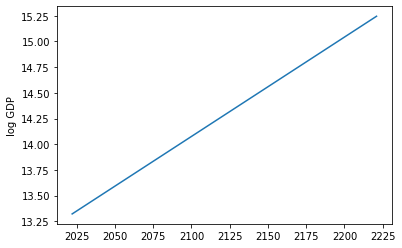

In [195]:
gdp_ = np.array([gdp(initial_gdp=initial_gdp,
                     gdp_growth=gdp_growth_p[GRAPH_P],
                     year=(y - CURRENT_YEAR)) for y in years])
plt.plot(years, np.log10(gdp_))
plt.ylabel('log GDP')

In [196]:
for y in years:
    print('Year: {} - GDP log$ {} ({})'.format(y,
                                               np.round(np.log10(gdp_[y - CURRENT_YEAR]), 1),
                                               numerize(np.log10(gdp_[y - CURRENT_YEAR]))))
    

Year: 2022 - GDP log$ 13.3 (10 trillion)
Year: 2023 - GDP log$ 13.3 (10 trillion)
Year: 2024 - GDP log$ 13.3 (10 trillion)
Year: 2025 - GDP log$ 13.4 (10 trillion)
Year: 2026 - GDP log$ 13.4 (10 trillion)
Year: 2027 - GDP log$ 13.4 (10 trillion)
Year: 2028 - GDP log$ 13.4 (10 trillion)
Year: 2029 - GDP log$ 13.4 (10 trillion)
Year: 2030 - GDP log$ 13.4 (10 trillion)
Year: 2031 - GDP log$ 13.4 (10 trillion)
Year: 2032 - GDP log$ 13.4 (10 trillion)
Year: 2033 - GDP log$ 13.4 (10 trillion)
Year: 2034 - GDP log$ 13.4 (10 trillion)
Year: 2035 - GDP log$ 13.4 (10 trillion)
Year: 2036 - GDP log$ 13.5 (10 trillion)
Year: 2037 - GDP log$ 13.5 (10 trillion)
Year: 2038 - GDP log$ 13.5 (10 trillion)
Year: 2039 - GDP log$ 13.5 (10 trillion)
Year: 2040 - GDP log$ 13.5 (10 trillion)
Year: 2041 - GDP log$ 13.5 (10 trillion)
Year: 2042 - GDP log$ 13.5 (10 trillion)
Year: 2043 - GDP log$ 13.5 (10 trillion)
Year: 2044 - GDP log$ 13.5 (10 trillion)
Year: 2045 - GDP log$ 13.5 (10 trillion)
Year: 2046 - GDP

## Willingness to Pay Over Time

Text(0, 0.5, 'log $ willing to spend on TAI')

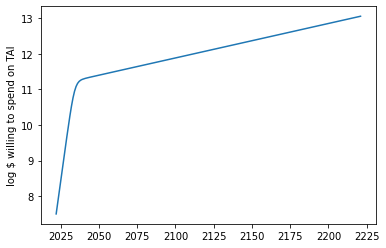

In [197]:
willingness = np.array([willingness_to_pay(initial_gdp=initial_gdp,
                                           gdp_growth=gdp_growth_p[GRAPH_P],
                                           initial_pay=10 ** initial_pay_p[GRAPH_P],
                                           spend_doubling_time=spend_doubling_time_p[GRAPH_P],
                                           max_gdp_frac=max_gdp_frac_p[GRAPH_P],
                                           year=(y - CURRENT_YEAR)) for y in years])

plt.plot(years, np.log10(willingness))
plt.ylabel('log $ willing to spend on TAI')


In [198]:
for y in years:
    print('Year: {} - willingness log$ {} ({})'.format(y,
                                                       np.round(np.log10(willingness[y - CURRENT_YEAR]), 1),
                                                       numerize(np.log10(willingness[y - CURRENT_YEAR]))))

Year: 2022 - willingness log$ 7.5 (10 million)
Year: 2023 - willingness log$ 7.8 (10 million)
Year: 2024 - willingness log$ 8.1 (100 million)
Year: 2025 - willingness log$ 8.4 (100 million)
Year: 2026 - willingness log$ 8.8 (100 million)
Year: 2027 - willingness log$ 9.1 (one billion)
Year: 2028 - willingness log$ 9.4 (one billion)
Year: 2029 - willingness log$ 9.7 (one billion)
Year: 2030 - willingness log$ 10.0 (one billion)
Year: 2031 - willingness log$ 10.3 (10 billion)
Year: 2032 - willingness log$ 10.5 (10 billion)
Year: 2033 - willingness log$ 10.8 (10 billion)
Year: 2034 - willingness log$ 10.9 (10 billion)
Year: 2035 - willingness log$ 11.1 (100 billion)
Year: 2036 - willingness log$ 11.2 (100 billion)
Year: 2037 - willingness log$ 11.2 (100 billion)
Year: 2038 - willingness log$ 11.3 (100 billion)
Year: 2039 - willingness log$ 11.3 (100 billion)
Year: 2040 - willingness log$ 11.3 (100 billion)
Year: 2041 - willingness log$ 11.3 (100 billion)
Year: 2042 - willingness log$ 11.3

## FLOPs Needed to Make TAI (Given Algorithmic Progress)

Text(0, 0.5, 'log FLOPs needed to make TAI')

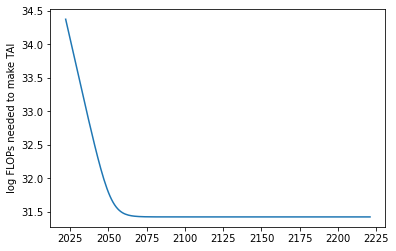

In [199]:
flops_ = np.array([flops_needed(initial_flops=10 ** initial_flops_p[GRAPH_P],
                                doubling_rate=algo_doubling_rate_p[GRAPH_P],
                                possible_reduction=10 ** possible_algo_reduction_fn(min_reduction_p[GRAPH_P], max_reduction_p[GRAPH_P], initial_flops_p[GRAPH_P]),
                                year=(y - CURRENT_YEAR)) for y in years])

plt.plot(years, np.log10(flops_))
plt.ylabel('log FLOPs needed to make TAI')


In [200]:
for y in years:
    print('Year: {} - log FLOPs needed for TAI {} ({})'.format(y,
                                                               np.round(np.log10(flops_[y - CURRENT_YEAR]), 1),
                                                               numerize(np.log10(flops_[y - CURRENT_YEAR]))))

Year: 2022 - log FLOPs needed for TAI 34.4 (10 decillion)
Year: 2023 - log FLOPs needed for TAI 34.3 (10 decillion)
Year: 2024 - log FLOPs needed for TAI 34.2 (10 decillion)
Year: 2025 - log FLOPs needed for TAI 34.1 (10 decillion)
Year: 2026 - log FLOPs needed for TAI 34.0 (one decillion)
Year: 2027 - log FLOPs needed for TAI 33.9 (one decillion)
Year: 2028 - log FLOPs needed for TAI 33.8 (one decillion)
Year: 2029 - log FLOPs needed for TAI 33.7 (one decillion)
Year: 2030 - log FLOPs needed for TAI 33.6 (one decillion)
Year: 2031 - log FLOPs needed for TAI 33.5 (one decillion)
Year: 2032 - log FLOPs needed for TAI 33.4 (one decillion)
Year: 2033 - log FLOPs needed for TAI 33.3 (one decillion)
Year: 2034 - log FLOPs needed for TAI 33.2 (one decillion)
Year: 2035 - log FLOPs needed for TAI 33.1 (one decillion)
Year: 2036 - log FLOPs needed for TAI 33.0 (100 nonillion)
Year: 2037 - log FLOPs needed for TAI 32.9 (100 nonillion)
Year: 2038 - log FLOPs needed for TAI 32.8 (100 nonillion)
Y

## FLOPs per Dollar (Given Declining Costs)

Text(0, 0.5, 'log FLOPs per $1')

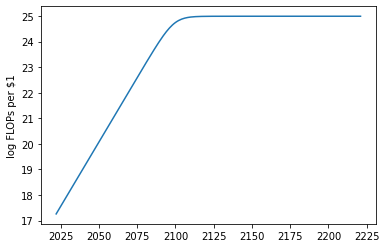

In [201]:
flops_per_dollar_ = np.array([flops_per_dollar(initial_flops_per_dollar=10 ** initial_flops_per_dollar_p[GRAPH_P],
                                               max_flops_per_dollar=10 ** max_flops_per_dollar_p[GRAPH_P],
                                               halving_rate=flops_halving_rate_p[GRAPH_P],
                                               year=(y - CURRENT_YEAR)) for y in years])
plt.plot(years, np.log10(flops_per_dollar_))
plt.ylabel('log FLOPs per $1')


In [202]:
for y in years:
    print('Year: {} - log {} FLOPs per $ ({})'.format(y,
                                                      np.round(np.log10(flops_per_dollar_[y - CURRENT_YEAR]), 1),
                                                      numerize(np.log10(flops_per_dollar_[y - CURRENT_YEAR]))))

Year: 2022 - log 17.3 FLOPs per $ (100 quadrillion)
Year: 2023 - log 17.4 FLOPs per $ (100 quadrillion)
Year: 2024 - log 17.5 FLOPs per $ (100 quadrillion)
Year: 2025 - log 17.6 FLOPs per $ (100 quadrillion)
Year: 2026 - log 17.7 FLOPs per $ (100 quadrillion)
Year: 2027 - log 17.8 FLOPs per $ (100 quadrillion)
Year: 2028 - log 17.9 FLOPs per $ (100 quadrillion)
Year: 2029 - log 18.0 FLOPs per $ (100 quadrillion)
Year: 2030 - log 18.1 FLOPs per $ (one quintillion)
Year: 2031 - log 18.2 FLOPs per $ (one quintillion)
Year: 2032 - log 18.3 FLOPs per $ (one quintillion)
Year: 2033 - log 18.4 FLOPs per $ (one quintillion)
Year: 2034 - log 18.5 FLOPs per $ (one quintillion)
Year: 2035 - log 18.6 FLOPs per $ (one quintillion)
Year: 2036 - log 18.7 FLOPs per $ (one quintillion)
Year: 2037 - log 18.8 FLOPs per $ (one quintillion)
Year: 2038 - log 18.9 FLOPs per $ (one quintillion)
Year: 2039 - log 19.0 FLOPs per $ (one quintillion)
Year: 2040 - log 19.1 FLOPs per $ (10 quintillion)
Year: 2041 - 

## Max Possible OOM Reduction in TAI FLOP Size

Text(0.5, 0, 'initial FLOP needed for TAI prior to any reduction')

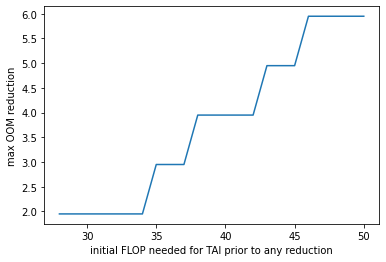

In [203]:
tai_sizes = range(28, 51)
flops_per_dollar_ = np.array([possible_algo_reduction_fn(min_reduction_p[GRAPH_P], max_reduction_p[GRAPH_P], t) for t in tai_sizes])
plt.plot(tai_sizes, flops_per_dollar_)
plt.ylabel('max OOM reduction')
plt.xlabel('initial FLOP needed for TAI prior to any reduction')

In [204]:
for t in tai_sizes:
    print('TAI log FLOP {} -> {} OOM reductions possible'.format(t,
                                                                 possible_algo_reduction_fn(min_reduction_p[GRAPH_P],
                                                                                            max_reduction_p[GRAPH_P],
                                                                                            t)))
          

TAI log FLOP 28 -> 1.9501136861606376 OOM reductions possible
TAI log FLOP 29 -> 1.9501136861606376 OOM reductions possible
TAI log FLOP 30 -> 1.9501136861606376 OOM reductions possible
TAI log FLOP 31 -> 1.9501136861606376 OOM reductions possible
TAI log FLOP 32 -> 1.9501136861606376 OOM reductions possible
TAI log FLOP 33 -> 1.9501136861606376 OOM reductions possible
TAI log FLOP 34 -> 1.9501136861606376 OOM reductions possible
TAI log FLOP 35 -> 2.9501136861606376 OOM reductions possible
TAI log FLOP 36 -> 2.9501136861606376 OOM reductions possible
TAI log FLOP 37 -> 2.9501136861606376 OOM reductions possible
TAI log FLOP 38 -> 3.9501136861606376 OOM reductions possible
TAI log FLOP 39 -> 3.9501136861606376 OOM reductions possible
TAI log FLOP 40 -> 3.9501136861606376 OOM reductions possible
TAI log FLOP 41 -> 3.9501136861606376 OOM reductions possible
TAI log FLOP 42 -> 3.9501136861606376 OOM reductions possible
TAI log FLOP 43 -> 4.950113686160638 OOM reductions possible
TAI log F

## Dollars Needed to Buy TAI (Given Algorithmic Progress and Decline in Cost per FLOP)

Text(0, 0.5, 'log $ needed to buy TAI')

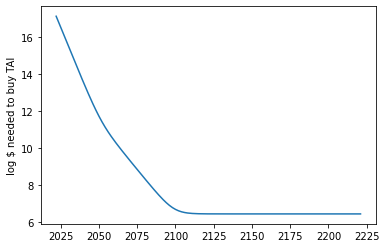

In [205]:
cost_of_tai_ = np.array([cost_of_tai(initial_flops=10 ** initial_flops_p[GRAPH_P],
                                     possible_reduction=10 ** possible_algo_reduction_fn(min_reduction_p[GRAPH_P], max_reduction_p[GRAPH_P], initial_flops_p[GRAPH_P]),
                                     algo_doubling_rate=algo_doubling_rate_p[GRAPH_P],
                                     initial_flops_per_dollar=10 ** initial_flops_per_dollar_p[GRAPH_P],
                                     max_flops_per_dollar=10 ** max_flops_per_dollar_p[GRAPH_P],
                                     flops_halving_rate=flops_halving_rate_p[GRAPH_P],
                                     year=(y - CURRENT_YEAR)) for y in years])

plt.plot(years, np.log10(cost_of_tai_))
plt.ylabel('log $ needed to buy TAI')


In [206]:
for y in years:
    print('Year: {} - log $ {} to buy TAI ({})'.format(y,
                                                       np.round(np.log10(cost_of_tai_[y - CURRENT_YEAR]), 1),
                                                       numerize(np.log10(cost_of_tai_[y - CURRENT_YEAR]))))

Year: 2022 - log $ 17.1 to buy TAI (100 quadrillion)
Year: 2023 - log $ 16.9 to buy TAI (10 quadrillion)
Year: 2024 - log $ 16.7 to buy TAI (10 quadrillion)
Year: 2025 - log $ 16.5 to buy TAI (10 quadrillion)
Year: 2026 - log $ 16.3 to buy TAI (10 quadrillion)
Year: 2027 - log $ 16.1 to buy TAI (10 quadrillion)
Year: 2028 - log $ 15.9 to buy TAI (one quadrillion)
Year: 2029 - log $ 15.7 to buy TAI (one quadrillion)
Year: 2030 - log $ 15.5 to buy TAI (one quadrillion)
Year: 2031 - log $ 15.3 to buy TAI (one quadrillion)
Year: 2032 - log $ 15.1 to buy TAI (one quadrillion)
Year: 2033 - log $ 14.9 to buy TAI (100 trillion)
Year: 2034 - log $ 14.7 to buy TAI (100 trillion)
Year: 2035 - log $ 14.5 to buy TAI (100 trillion)
Year: 2036 - log $ 14.3 to buy TAI (100 trillion)
Year: 2037 - log $ 14.1 to buy TAI (100 trillion)
Year: 2038 - log $ 13.9 to buy TAI (10 trillion)
Year: 2039 - log $ 13.7 to buy TAI (10 trillion)
Year: 2040 - log $ 13.5 to buy TAI (10 trillion)
Year: 2041 - log $ 13.3 t

## FLOPs at Max Spend

Text(0, 0.5, 'max log FLOPs bought given willingness to spend')

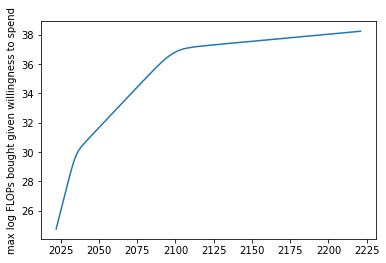

In [207]:
flops_at_max_ = np.array([flops_at_max(initial_gdp=initial_gdp,
                                       gdp_growth=gdp_growth_p[GRAPH_P],
                                       initial_pay=10 ** initial_pay_p[GRAPH_P],
                                       spend_doubling_time=spend_doubling_time_p[GRAPH_P],
                                       max_gdp_frac=max_gdp_frac_p[GRAPH_P],
                                       initial_flops_per_dollar=10 ** initial_flops_per_dollar_p[GRAPH_P],
                                       max_flops_per_dollar=10 ** max_flops_per_dollar_p[GRAPH_P],
                                       flops_halving_rate=flops_halving_rate_p[GRAPH_P],
                                       year=(y - CURRENT_YEAR)) for y in years])

plt.plot(years, np.log10(flops_at_max_))
plt.ylabel('max log FLOPs bought given willingness to spend')


In [208]:
for y in years:
    print('Year: {} - max log FLOPs {} ({})'.format(y,
                                                    np.round(np.log10(flops_at_max_[y - CURRENT_YEAR]), 1),
                                                    numerize(np.log10(flops_at_max_[y - CURRENT_YEAR]))))

Year: 2022 - max log FLOPs 24.8 (one septillion)
Year: 2023 - max log FLOPs 25.2 (10 septillion)
Year: 2024 - max log FLOPs 25.6 (10 septillion)
Year: 2025 - max log FLOPs 26.0 (100 septillion)
Year: 2026 - max log FLOPs 26.4 (100 septillion)
Year: 2027 - max log FLOPs 26.8 (100 septillion)
Year: 2028 - max log FLOPs 27.2 (one octillion)
Year: 2029 - max log FLOPs 27.6 (one octillion)
Year: 2030 - max log FLOPs 28.0 (10 octillion)
Year: 2031 - max log FLOPs 28.4 (10 octillion)
Year: 2032 - max log FLOPs 28.8 (10 octillion)
Year: 2033 - max log FLOPs 29.2 (100 octillion)
Year: 2034 - max log FLOPs 29.5 (100 octillion)
Year: 2035 - max log FLOPs 29.8 (100 octillion)
Year: 2036 - max log FLOPs 30.0 (100 octillion)
Year: 2037 - max log FLOPs 30.2 (one nonillion)
Year: 2038 - max log FLOPs 30.3 (one nonillion)
Year: 2039 - max log FLOPs 30.4 (one nonillion)
Year: 2040 - max log FLOPs 30.6 (one nonillion)
Year: 2041 - max log FLOPs 30.7 (one nonillion)
Year: 2042 - max log FLOPs 30.8 (one no

## Chance of Non-scaling Delay

Text(0, 0.5, 'chance of non-scaling delay by year')

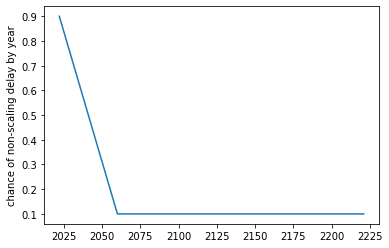

In [209]:
p_nonscaling_delay_ = np.array([p_nonscaling_delay(initial_chance_of_nonscaling_issue,
                                                   final_chance_of_nonscaling_issue,
                                                   year=y,
                                                   max_year=nonscaling_issue_bottom_year) for y in years])

plt.plot(years, p_nonscaling_delay_)
plt.ylabel('chance of non-scaling delay by year')
# TODO: Make logistic?

In [210]:
for y in years:
    print('Year: {} - p(nonscaling delay) = {}%'.format(y,
                                                        np.round(p_nonscaling_delay_[y - CURRENT_YEAR] * 100, 1)))

Year: 2022 - p(nonscaling delay) = 90.0%
Year: 2023 - p(nonscaling delay) = 87.9%
Year: 2024 - p(nonscaling delay) = 85.8%
Year: 2025 - p(nonscaling delay) = 83.7%
Year: 2026 - p(nonscaling delay) = 81.6%
Year: 2027 - p(nonscaling delay) = 79.5%
Year: 2028 - p(nonscaling delay) = 77.4%
Year: 2029 - p(nonscaling delay) = 75.3%
Year: 2030 - p(nonscaling delay) = 73.2%
Year: 2031 - p(nonscaling delay) = 71.1%
Year: 2032 - p(nonscaling delay) = 68.9%
Year: 2033 - p(nonscaling delay) = 66.8%
Year: 2034 - p(nonscaling delay) = 64.7%
Year: 2035 - p(nonscaling delay) = 62.6%
Year: 2036 - p(nonscaling delay) = 60.5%
Year: 2037 - p(nonscaling delay) = 58.4%
Year: 2038 - p(nonscaling delay) = 56.3%
Year: 2039 - p(nonscaling delay) = 54.2%
Year: 2040 - p(nonscaling delay) = 52.1%
Year: 2041 - p(nonscaling delay) = 50.0%
Year: 2042 - p(nonscaling delay) = 47.9%
Year: 2043 - p(nonscaling delay) = 45.8%
Year: 2044 - p(nonscaling delay) = 43.7%
Year: 2045 - p(nonscaling delay) = 41.6%
Year: 2046 - p(n

## Chance of Rapid Recursive Self-Improvement

Text(0.5, 0, 'percentage of TAI-level FLOP')

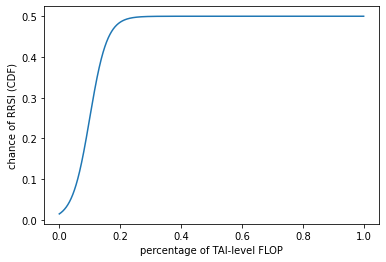

In [211]:
p_rrsi_ = np.array([p_rapid_recursive_self_improvement(10000,
                                                       x,
                                                       base_p_recursive,
                                                       recursive_curve_steepness,
                                                       recursive_curve_inflection) for x in range(10000)])

plt.plot([r / 10000 for r in range(10000)], p_rrsi_)
plt.ylabel('chance of RRSI (CDF)')
plt.xlabel('percentage of TAI-level FLOP')

In [212]:
samples = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200,
           1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
for i in samples:
    print('Ratio: {} in 10000 - p(RRSI) (CDF) = {}%'.format(i, np.round(p_rrsi_[i-1] * 100, 1)))

Ratio: 1 in 10000 - p(RRSI) (CDF) = 1.5%
Ratio: 5 in 10000 - p(RRSI) (CDF) = 1.5%
Ratio: 10 in 10000 - p(RRSI) (CDF) = 1.5%
Ratio: 20 in 10000 - p(RRSI) (CDF) = 1.6%
Ratio: 30 in 10000 - p(RRSI) (CDF) = 1.6%
Ratio: 40 in 10000 - p(RRSI) (CDF) = 1.7%
Ratio: 50 in 10000 - p(RRSI) (CDF) = 1.7%
Ratio: 60 in 10000 - p(RRSI) (CDF) = 1.8%
Ratio: 70 in 10000 - p(RRSI) (CDF) = 1.9%
Ratio: 80 in 10000 - p(RRSI) (CDF) = 1.9%
Ratio: 90 in 10000 - p(RRSI) (CDF) = 2.0%
Ratio: 100 in 10000 - p(RRSI) (CDF) = 2.0%
Ratio: 200 in 10000 - p(RRSI) (CDF) = 2.9%
Ratio: 300 in 10000 - p(RRSI) (CDF) = 4.0%
Ratio: 400 in 10000 - p(RRSI) (CDF) = 5.4%
Ratio: 500 in 10000 - p(RRSI) (CDF) = 7.4%
Ratio: 600 in 10000 - p(RRSI) (CDF) = 9.9%
Ratio: 700 in 10000 - p(RRSI) (CDF) = 12.9%
Ratio: 800 in 10000 - p(RRSI) (CDF) = 16.6%
Ratio: 900 in 10000 - p(RRSI) (CDF) = 20.6%
Ratio: 1000 in 10000 - p(RRSI) (CDF) = 25.0%
Ratio: 1100 in 10000 - p(RRSI) (CDF) = 29.3%
Ratio: 1200 in 10000 - p(RRSI) (CDF) = 33.4%
Ratio: 1300 in 

## Run Model

Running
## RUN 1/10000 ##
Diagnostic: tai_flop_size=35.85418055771407, nonscaling_delay=10.846086274698964, algo_doubling_rate=1.7785075147989984, possible_algo_reduction=2.9924545782916976, initial_flops_per_dollar=1.1310091657086211e+17, flops_halving_rate=1.8691444258801175, max_flops_per_dollar=6.703432087663125e+25, initial_pay=21433413.413012184, gdp_growth=1.0174838477355534, max_gdp_frac=0.0031149961207809305, willingness_ramp=0.7130862814861193, spend_doubling_time=0.7302909689298173
-
It takes 35.9 log FLOPs (100 decillion) for transformative capabilities.
Every 1.8 years algorithms get 2x better, with 3.0 log reductions possible.
FLOPs start at a cost of 17.1 log FLOPs (100 quadrillion) per $. Every 1.9 years they get 2x cheaper, to a maximum of 25.8 log FLOPs (10 septillion) per $.
We are willing to pay 7.3 log $ (10 million) and this increases by 0.7x per year to a max of 0.0031% of GDP. GDP grows at a rate of 1.017x per year.
If we are 71.0% of the way to paying for TAI, 

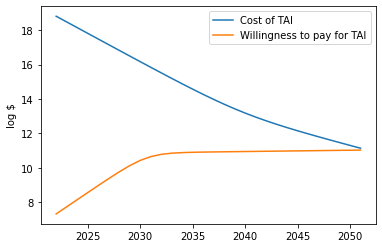

## RUN 2/10000 ##
Diagnostic: tai_flop_size=34.127902065710096, nonscaling_delay=2.3693619301793665, algo_doubling_rate=2.803285335099343, possible_algo_reduction=3.77654218222005, initial_flops_per_dollar=1.2360516241790203e+17, flops_halving_rate=2.1949009058104516, max_flops_per_dollar=5.948219010246585e+24, initial_pay=81880817.27964775, gdp_growth=1.0235061082171875, max_gdp_frac=0.001727204098211844, willingness_ramp=0.8452146979303125, spend_doubling_time=1.2363145598957828
-
It takes 34.1 log FLOPs (10 decillion) for transformative capabilities.
Every 2.8 years algorithms get 2x better, with 3.8 log reductions possible.
FLOPs start at a cost of 17.1 log FLOPs (100 quadrillion) per $. Every 2.2 years they get 2x cheaper, to a maximum of 24.8 log FLOPs (one septillion) per $.
We are willing to pay 7.9 log $ (10 million) and this increases by 1.2x per year to a max of 0.0017% of GDP. GDP grows at a rate of 1.024x per year.
If we are 85.0% of the way to paying for TAI, we will ramp

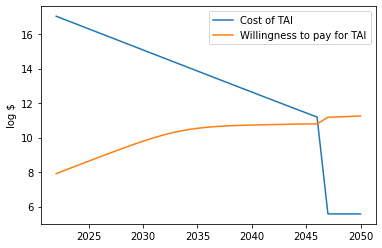

## RUN 3/10000 ##
Diagnostic: tai_flop_size=34.53179022796841, nonscaling_delay=1.0691108550301032, algo_doubling_rate=1.5338767611166424, possible_algo_reduction=2.9148862429723956, initial_flops_per_dollar=1.7095997837418618e+17, flops_halving_rate=2.524086844526717, max_flops_per_dollar=1.2654759073053554e+25, initial_pay=30268866.541890897, gdp_growth=1.0300810125253492, max_gdp_frac=0.00675230155582867, willingness_ramp=0.8654823953461929, spend_doubling_time=0.7539913960989462
-
It takes 34.5 log FLOPs (10 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 2.9 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 2.5 years they get 2x cheaper, to a maximum of 25.1 log FLOPs (10 septillion) per $.
We are willing to pay 7.5 log $ (10 million) and this increases by 0.8x per year to a max of 0.0068% of GDP. GDP grows at a rate of 1.03x per year.
If we are 87.0% of the way to paying for TAI, we will ramp

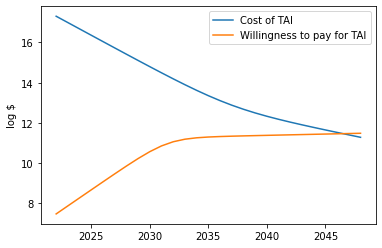

## RUN 4/10000 ##
Diagnostic: tai_flop_size=27.185798969333003, nonscaling_delay=1.5159669058501177, algo_doubling_rate=5.948091377980546, possible_algo_reduction=0.9604474824481197, initial_flops_per_dollar=1.5267287851878422e+17, flops_halving_rate=3.869796734975419, max_flops_per_dollar=2.556383925876299e+25, initial_pay=28271858.04516096, gdp_growth=1.0165515772815548, max_gdp_frac=0.0261020267027597, willingness_ramp=0.6490464913949401, spend_doubling_time=1.3277389934877182
-
It takes 27.2 log FLOPs (one octillion) for transformative capabilities.
Every 5.9 years algorithms get 2x better, with 1.0 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 3.9 years they get 2x cheaper, to a maximum of 25.4 log FLOPs (10 septillion) per $.
We are willing to pay 7.5 log $ (10 million) and this increases by 1.3x per year to a max of 0.0261% of GDP. GDP grows at a rate of 1.017x per year.
If we are 65.0% of the way to paying for TAI, we will ramp 

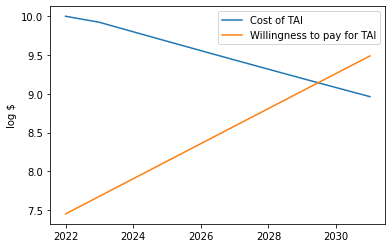

## RUN 5/10000 ##
Diagnostic: tai_flop_size=39.081846071473784, nonscaling_delay=5.438175845905155, algo_doubling_rate=1, possible_algo_reduction=4.438054594093785, initial_flops_per_dollar=1.7575552451799117e+17, flops_halving_rate=3.5681638555506314, max_flops_per_dollar=1.7652191669300692e+25, initial_pay=9717938.634468572, gdp_growth=1.0166928705921694, max_gdp_frac=0.0032492163156845233, willingness_ramp=0.7932179011475694, spend_doubling_time=1.3319769893211975
-
It takes 39.1 log FLOPs (one million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4.4 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 3.6 years they get 2x cheaper, to a maximum of 25.2 log FLOPs (10 septillion) per $.
We are willing to pay 7.0 log $ (one million) and this increases by 1.3x per year to a max of 0.0032% of GDP. GDP grows at a rate of 1.017x per year.
If we are 79.0% of the way to paying for TAI, we will ramp to pay

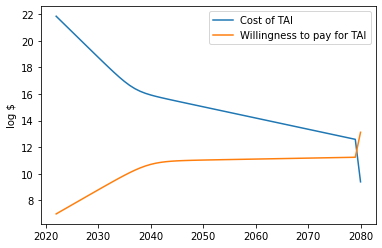

## RUN 6/10000 ##
Diagnostic: tai_flop_size=29.476361892349438, nonscaling_delay=11.276251749352422, algo_doubling_rate=4.371369421175416, possible_algo_reduction=2.413466638237343, initial_flops_per_dollar=8.814910264271706e+16, flops_halving_rate=3.1705676571670396, max_flops_per_dollar=1.9155973456400027e+26, initial_pay=7939833.277179241, gdp_growth=1.0266780422999733, max_gdp_frac=0.0015, willingness_ramp=0.8160699843673496, spend_doubling_time=3.4856317129281287
-
It takes 29.5 log FLOPs (100 octillion) for transformative capabilities.
Every 4.4 years algorithms get 2x better, with 2.4 log reductions possible.
FLOPs start at a cost of 16.9 log FLOPs (10 quadrillion) per $. Every 3.2 years they get 2x cheaper, to a maximum of 26.3 log FLOPs (100 septillion) per $.
We are willing to pay 6.9 log $ (one million) and this increases by 3.5x per year to a max of 0.0015% of GDP. GDP grows at a rate of 1.027x per year.
If we are 82.0% of the way to paying for TAI, we will ramp to paying f

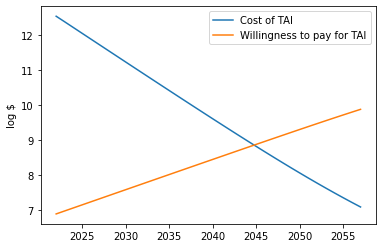

## RUN 7/10000 ##
Diagnostic: tai_flop_size=39.960995620732696, nonscaling_delay=7.462372584601786, algo_doubling_rate=3.516818280507192, possible_algo_reduction=2.896743107886082, initial_flops_per_dollar=1.0201416670149941e+17, flops_halving_rate=3.0993771550314717, max_flops_per_dollar=2.4070301111622926e+24, initial_pay=22492065.898553345, gdp_growth=1.0191372377139072, max_gdp_frac=0.0038758053820280255, willingness_ramp=0.920971309444389, spend_doubling_time=0.9399355753254326
-
It takes 40.0 log FLOPs (one million decillion) for transformative capabilities.
Every 3.5 years algorithms get 2x better, with 2.9 log reductions possible.
FLOPs start at a cost of 17.0 log FLOPs (100 quadrillion) per $. Every 3.1 years they get 2x cheaper, to a maximum of 24.4 log FLOPs (one septillion) per $.
We are willing to pay 7.4 log $ (10 million) and this increases by 0.9x per year to a max of 0.0039% of GDP. GDP grows at a rate of 1.019x per year.
If we are 92.0% of the way to paying for TAI, w

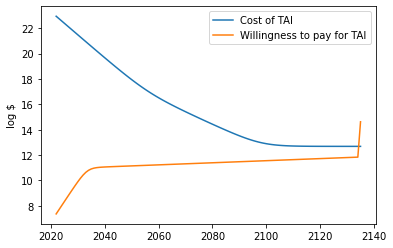

## RUN 8/10000 ##
Diagnostic: tai_flop_size=24.99993513300988, nonscaling_delay=2.6160081273243474, algo_doubling_rate=3.312808358387614, possible_algo_reduction=2.1917287783673056, initial_flops_per_dollar=7.956806272895552e+16, flops_halving_rate=3.2942781874186453, max_flops_per_dollar=3.2219344152388473e+24, initial_pay=88848868.12464607, gdp_growth=1.0188676395687426, max_gdp_frac=0.0025550731135880185, willingness_ramp=0.894519948670495, spend_doubling_time=0.5
-
It takes 25.0 log FLOPs (one septillion) for transformative capabilities.
Every 3.3 years algorithms get 2x better, with 2.2 log reductions possible.
FLOPs start at a cost of 16.9 log FLOPs (10 quadrillion) per $. Every 3.3 years they get 2x cheaper, to a maximum of 24.5 log FLOPs (one septillion) per $.
We are willing to pay 7.9 log $ (10 million) and this increases by 0.5x per year to a max of 0.0026% of GDP. GDP grows at a rate of 1.019x per year.
If we are 89.0% of the way to paying for TAI, we will ramp to paying fo

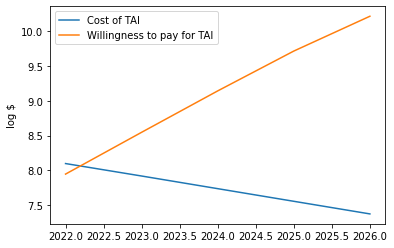

## RUN 9/10000 ##
Diagnostic: tai_flop_size=35.31955210168226, nonscaling_delay=3.8613391403009656, algo_doubling_rate=3.2905524454364903, possible_algo_reduction=2.818911022164844, initial_flops_per_dollar=1.432945783631003e+17, flops_halving_rate=3.7733022596167665, max_flops_per_dollar=2.622730793676958e+25, initial_pay=72561699.57782875, gdp_growth=1.020956039971181, max_gdp_frac=0.05012797988556434, willingness_ramp=0.8836442648921696, spend_doubling_time=1.3779471223246962
-
It takes 35.3 log FLOPs (100 decillion) for transformative capabilities.
Every 3.3 years algorithms get 2x better, with 2.8 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 3.8 years they get 2x cheaper, to a maximum of 25.4 log FLOPs (10 septillion) per $.
We are willing to pay 7.9 log $ (10 million) and this increases by 1.4x per year to a max of 0.0501% of GDP. GDP grows at a rate of 1.021x per year.
If we are 88.0% of the way to paying for TAI, we will ramp t

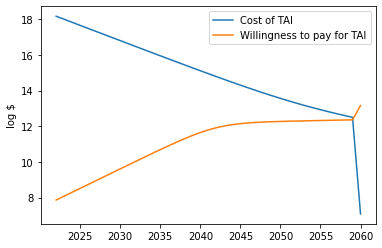

## RUN 10/10000 ##
Diagnostic: tai_flop_size=33.422378827421085, nonscaling_delay=4.349004015799928, algo_doubling_rate=3.803683743159758, possible_algo_reduction=0.7987418557254793, initial_flops_per_dollar=2.6148748265467578e+17, flops_halving_rate=2.975566653199652, max_flops_per_dollar=1.4959480562341216e+25, initial_pay=136308316.70286125, gdp_growth=1.0162138645156162, max_gdp_frac=0.03521040874476896, willingness_ramp=0.8315476234035252, spend_doubling_time=1.0380645657666376
-
It takes 33.4 log FLOPs (one decillion) for transformative capabilities.
Every 3.8 years algorithms get 2x better, with 0.8 log reductions possible.
FLOPs start at a cost of 17.4 log FLOPs (100 quadrillion) per $. Every 3.0 years they get 2x cheaper, to a maximum of 25.2 log FLOPs (10 septillion) per $.
We are willing to pay 8.1 log $ (100 million) and this increases by 1.0x per year to a max of 0.0352% of GDP. GDP grows at a rate of 1.016x per year.
If we are 83.0% of the way to paying for TAI, we will r

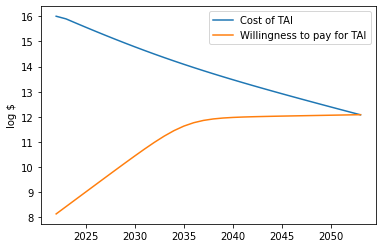

## RUN 11/10000 ##
Diagnostic: tai_flop_size=28.436345145360615, nonscaling_delay=3.9671609259496767, algo_doubling_rate=2.418759280599436, possible_algo_reduction=1.6065350953424111, initial_flops_per_dollar=1.952742917200898e+17, flops_halving_rate=1.996299869258459, max_flops_per_dollar=1.7442966508227995e+24, initial_pay=48477496.054861166, gdp_growth=1.0263491778832714, max_gdp_frac=0.0053458839030851996, willingness_ramp=0.8990660960331175, spend_doubling_time=0.691117675635184
-
It takes 28.4 log FLOPs (10 octillion) for transformative capabilities.
Every 2.4 years algorithms get 2x better, with 1.6 log reductions possible.
FLOPs start at a cost of 17.3 log FLOPs (100 quadrillion) per $. Every 2.0 years they get 2x cheaper, to a maximum of 24.2 log FLOPs (one septillion) per $.
We are willing to pay 7.7 log $ (10 million) and this increases by 0.7x per year to a max of 0.0053% of GDP. GDP grows at a rate of 1.026x per year.
If we are 90.0% of the way to paying for TAI, we will r

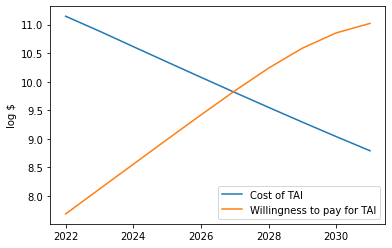

## RUN 12/10000 ##
Diagnostic: tai_flop_size=37.08158033936365, nonscaling_delay=7.185099410738899, algo_doubling_rate=5.388082252523498, possible_algo_reduction=3.2283256654449066, initial_flops_per_dollar=1.4353382938402971e+17, flops_halving_rate=1.3264241251268714, max_flops_per_dollar=1.0122581612133278e+25, initial_pay=26442049.41980235, gdp_growth=1.022444825357644, max_gdp_frac=0.00398880050209411, willingness_ramp=0.7539481258891348, spend_doubling_time=0.5
-
It takes 37.1 log FLOPs (10 thousand decillion) for transformative capabilities.
Every 5.4 years algorithms get 2x better, with 3.2 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 1.3 years they get 2x cheaper, to a maximum of 25.0 log FLOPs (10 septillion) per $.
We are willing to pay 7.4 log $ (10 million) and this increases by 0.5x per year to a max of 0.004% of GDP. GDP grows at a rate of 1.022x per year.
If we are 75.0% of the way to paying for TAI, we will ramp to payi

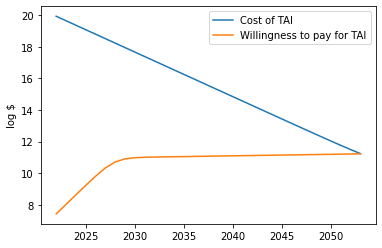

## RUN 13/10000 ##
Diagnostic: tai_flop_size=36.32108856654546, nonscaling_delay=5.36098459475144, algo_doubling_rate=3.848754863027936, possible_algo_reduction=3.1633248203164452, initial_flops_per_dollar=1.545558375596514e+17, flops_halving_rate=3.193882675560101, max_flops_per_dollar=9.518439731374283e+24, initial_pay=21555333.881514497, gdp_growth=1.0237593133459528, max_gdp_frac=0.030264122762230814, willingness_ramp=0.8240702067420237, spend_doubling_time=1.7054295448977745
-
It takes 36.3 log FLOPs (one thousand decillion) for transformative capabilities.
Every 3.8 years algorithms get 2x better, with 3.2 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 3.2 years they get 2x cheaper, to a maximum of 25.0 log FLOPs (one septillion) per $.
We are willing to pay 7.3 log $ (10 million) and this increases by 1.7x per year to a max of 0.0303% of GDP. GDP grows at a rate of 1.024x per year.
If we are 82.0% of the way to paying for TAI, we 

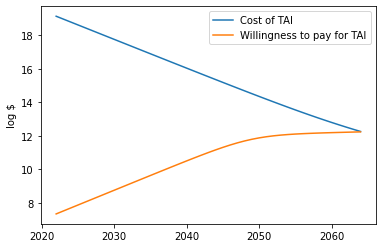

## RUN 14/10000 ##
Diagnostic: tai_flop_size=33.910682538014555, nonscaling_delay=1.7002680171931022, algo_doubling_rate=2.858424990558323, possible_algo_reduction=3.2490224470636972, initial_flops_per_dollar=3.070917108833944e+17, flops_halving_rate=2.034207203435155, max_flops_per_dollar=2.1365361592354787e+25, initial_pay=49778680.96985629, gdp_growth=1.0201638423051855, max_gdp_frac=0.005579705342136838, willingness_ramp=0.8743195796542501, spend_doubling_time=0.8615767971400272
-
It takes 33.9 log FLOPs (one decillion) for transformative capabilities.
Every 2.9 years algorithms get 2x better, with 3.2 log reductions possible.
FLOPs start at a cost of 17.5 log FLOPs (100 quadrillion) per $. Every 2.0 years they get 2x cheaper, to a maximum of 25.3 log FLOPs (10 septillion) per $.
We are willing to pay 7.7 log $ (10 million) and this increases by 0.9x per year to a max of 0.0056% of GDP. GDP grows at a rate of 1.02x per year.
If we are 87.0% of the way to paying for TAI, we will ram

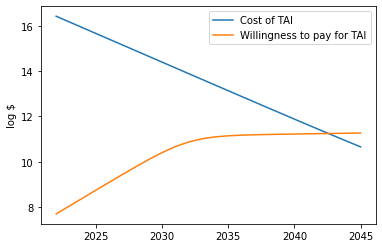

## RUN 15/10000 ##
Diagnostic: tai_flop_size=32.10906192509219, nonscaling_delay=6.44086579285624, algo_doubling_rate=3.344502344546794, possible_algo_reduction=2.2222986234104942, initial_flops_per_dollar=1.4504080177275946e+17, flops_halving_rate=3.615048742662871, max_flops_per_dollar=7.064479606972654e+25, initial_pay=92676287.05422647, gdp_growth=1.022998666934584, max_gdp_frac=0.016042430264628753, willingness_ramp=0.8306001876067504, spend_doubling_time=1.116513347785695
-
It takes 32.1 log FLOPs (100 nonillion) for transformative capabilities.
Every 3.3 years algorithms get 2x better, with 2.2 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 3.6 years they get 2x cheaper, to a maximum of 25.8 log FLOPs (10 septillion) per $.
We are willing to pay 8.0 log $ (10 million) and this increases by 1.1x per year to a max of 0.016% of GDP. GDP grows at a rate of 1.023x per year.
If we are 83.0% of the way to paying for TAI, we will ramp to 

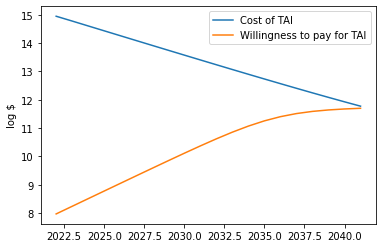

## RUN 16/10000 ##
Diagnostic: tai_flop_size=41.74995823280355, nonscaling_delay=9.39388878150865, algo_doubling_rate=5.897806516728577, possible_algo_reduction=4.378660111573787, initial_flops_per_dollar=1.980409741313267e+17, flops_halving_rate=1.9689642246387928, max_flops_per_dollar=2.9377677325472155e+25, initial_pay=26934279.238713466, gdp_growth=1.028503148236958, max_gdp_frac=0.0021664049449949263, willingness_ramp=0.9560598196960326, spend_doubling_time=1.2585905987122978
-
It takes 41.7 log FLOPs (100 million decillion) for transformative capabilities.
Every 5.9 years algorithms get 2x better, with 4.4 log reductions possible.
FLOPs start at a cost of 17.3 log FLOPs (100 quadrillion) per $. Every 2.0 years they get 2x cheaper, to a maximum of 25.5 log FLOPs (10 septillion) per $.
We are willing to pay 7.4 log $ (10 million) and this increases by 1.3x per year to a max of 0.0022% of GDP. GDP grows at a rate of 1.029x per year.
If we are 96.0% of the way to paying for TAI, we w

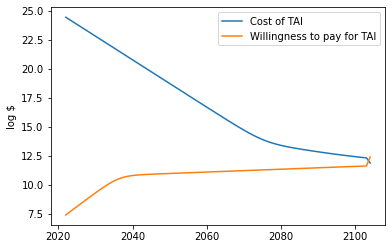

## RUN 17/10000 ##
Diagnostic: tai_flop_size=33.34074308754901, nonscaling_delay=2.3191501201231137, algo_doubling_rate=3.735562333491307, possible_algo_reduction=3.4596651009135444, initial_flops_per_dollar=2.4104048174747242e+17, flops_halving_rate=2.553502732438577, max_flops_per_dollar=5.470097019288665e+24, initial_pay=23101127.82306751, gdp_growth=1.0230050885002027, max_gdp_frac=0.006320519995428086, willingness_ramp=0.7381412946408038, spend_doubling_time=1.0221012962223375
-
It takes 33.3 log FLOPs (one decillion) for transformative capabilities.
Every 3.7 years algorithms get 2x better, with 3.5 log reductions possible.
FLOPs start at a cost of 17.4 log FLOPs (100 quadrillion) per $. Every 2.6 years they get 2x cheaper, to a maximum of 24.7 log FLOPs (one septillion) per $.
We are willing to pay 7.4 log $ (10 million) and this increases by 1.0x per year to a max of 0.0063% of GDP. GDP grows at a rate of 1.023x per year.
If we are 74.0% of the way to paying for TAI, we will ra

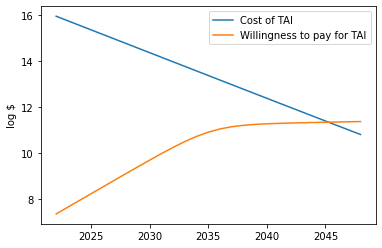

## RUN 18/10000 ##
Diagnostic: tai_flop_size=36.63515560667859, nonscaling_delay=6.864605648608785, algo_doubling_rate=4.257141517712534, possible_algo_reduction=2.740276888696739, initial_flops_per_dollar=2.0302486513237712e+17, flops_halving_rate=2.3133914319825393, max_flops_per_dollar=9.82365819941367e+23, initial_pay=32971184.143835235, gdp_growth=1.0165589351271165, max_gdp_frac=0.008383670705553216, willingness_ramp=0.8411618532069578, spend_doubling_time=0.9727476578584889
-
It takes 36.6 log FLOPs (one thousand decillion) for transformative capabilities.
Every 4.3 years algorithms get 2x better, with 2.7 log reductions possible.
FLOPs start at a cost of 17.3 log FLOPs (100 quadrillion) per $. Every 2.3 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (100 sextillion) per $.
We are willing to pay 7.5 log $ (10 million) and this increases by 1.0x per year to a max of 0.0084% of GDP. GDP grows at a rate of 1.017x per year.
If we are 84.0% of the way to paying for TAI, we

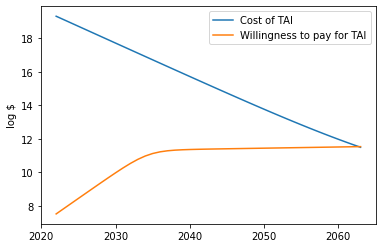

## RUN 19/10000 ##
Diagnostic: tai_flop_size=46.58259691021218, nonscaling_delay=3.8849757845258615, algo_doubling_rate=2.453217375407876, possible_algo_reduction=4.754540550432272, initial_flops_per_dollar=1.0057523003462928e+17, flops_halving_rate=1.667278813241239, max_flops_per_dollar=3.355302891354487e+25, initial_pay=41540499.30702752, gdp_growth=1.0224014222709943, max_gdp_frac=0.006567843345849004, willingness_ramp=0.9077008140679511, spend_doubling_time=0.8133761540439584
-
It takes 46.6 log FLOPs (10 trillion decillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 4.8 log reductions possible.
FLOPs start at a cost of 17.0 log FLOPs (100 quadrillion) per $. Every 1.7 years they get 2x cheaper, to a maximum of 25.5 log FLOPs (10 septillion) per $.
We are willing to pay 7.6 log $ (10 million) and this increases by 0.8x per year to a max of 0.0066% of GDP. GDP grows at a rate of 1.022x per year.
If we are 91.0% of the way to paying for TAI, we w

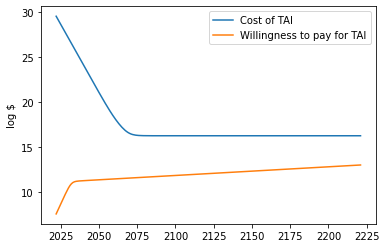

## RUN 20/10000 ##
Diagnostic: tai_flop_size=30.13701067809805, nonscaling_delay=4.884355014262889, algo_doubling_rate=2.751050516790806, possible_algo_reduction=2.642335286626487, initial_flops_per_dollar=1.5469245303830698e+17, flops_halving_rate=2.591440744795949, max_flops_per_dollar=3.2349001340833337e+24, initial_pay=9814932.288881948, gdp_growth=1.0219156375501812, max_gdp_frac=0.004093352157845206, willingness_ramp=0.9163204489705145, spend_doubling_time=1.1288856613166083
-
It takes 30.1 log FLOPs (one nonillion) for transformative capabilities.
Every 2.8 years algorithms get 2x better, with 2.6 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 2.6 years they get 2x cheaper, to a maximum of 24.5 log FLOPs (one septillion) per $.
We are willing to pay 7.0 log $ (one million) and this increases by 1.1x per year to a max of 0.0041% of GDP. GDP grows at a rate of 1.022x per year.
If we are 92.0% of the way to paying for TAI, we will ra

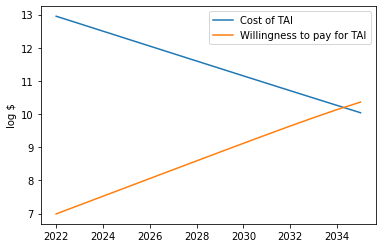

## RUN 21/10000 ##
Diagnostic: tai_flop_size=44.12083417299079, nonscaling_delay=0.8700315610894688, algo_doubling_rate=3.7826731432117535, possible_algo_reduction=5.3113031759044524, initial_flops_per_dollar=2.2693836801400752e+17, flops_halving_rate=3.1755983911435046, max_flops_per_dollar=4.585051232890886e+25, initial_pay=45682933.22999529, gdp_growth=1.0181273278588643, max_gdp_frac=0.009211272891355392, willingness_ramp=1.0070664308373125, spend_doubling_time=0.5898723431626057
-
It takes 44.1 log FLOPs (100 billion decillion) for transformative capabilities.
Every 3.8 years algorithms get 2x better, with 5.3 log reductions possible.
FLOPs start at a cost of 17.4 log FLOPs (100 quadrillion) per $. Every 3.2 years they get 2x cheaper, to a maximum of 25.7 log FLOPs (10 septillion) per $.
We are willing to pay 7.7 log $ (10 million) and this increases by 0.6x per year to a max of 0.0092% of GDP. GDP grows at a rate of 1.018x per year.
If we are 101.0% of the way to paying for TAI, 

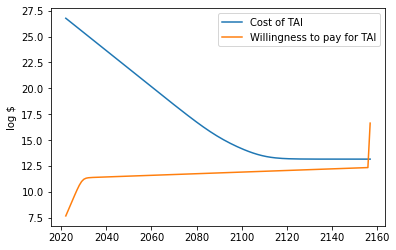

## RUN 22/10000 ##
Diagnostic: tai_flop_size=36.84328302563152, nonscaling_delay=4.71757451911081, algo_doubling_rate=3.5531222273753036, possible_algo_reduction=1.852976494286213, initial_flops_per_dollar=9.015188685879584e+16, flops_halving_rate=2.9571629083508664, max_flops_per_dollar=5.6520300608686555e+25, initial_pay=31374480.659040093, gdp_growth=1.0265471617915785, max_gdp_frac=0.004525029078635077, willingness_ramp=0.7576165177291764, spend_doubling_time=0.5822920497501273
-
It takes 36.8 log FLOPs (one thousand decillion) for transformative capabilities.
Every 3.6 years algorithms get 2x better, with 1.9 log reductions possible.
FLOPs start at a cost of 17.0 log FLOPs (10 quadrillion) per $. Every 3.0 years they get 2x cheaper, to a maximum of 25.8 log FLOPs (10 septillion) per $.
We are willing to pay 7.5 log $ (10 million) and this increases by 0.6x per year to a max of 0.0045% of GDP. GDP grows at a rate of 1.027x per year.
If we are 76.0% of the way to paying for TAI, we 

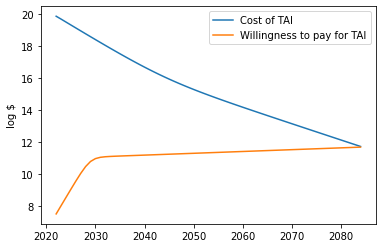

## RUN 23/10000 ##
Diagnostic: tai_flop_size=26.685644555021558, nonscaling_delay=5.067488715645794, algo_doubling_rate=3.1816009158781595, possible_algo_reduction=1.8084201923932393, initial_flops_per_dollar=1.5653417056436806e+17, flops_halving_rate=3.270308359294265, max_flops_per_dollar=3.4482228444234784e+24, initial_pay=33110903.227784973, gdp_growth=1.0191221218781392, max_gdp_frac=0.00161525065260072, willingness_ramp=0.9728853893412639, spend_doubling_time=1.1679241288411824
-
It takes 26.7 log FLOPs (100 septillion) for transformative capabilities.
Every 3.2 years algorithms get 2x better, with 1.8 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 3.3 years they get 2x cheaper, to a maximum of 24.5 log FLOPs (one septillion) per $.
We are willing to pay 7.5 log $ (10 million) and this increases by 1.2x per year to a max of 0.0016% of GDP. GDP grows at a rate of 1.019x per year.
If we are 97.0% of the way to paying for TAI, we will

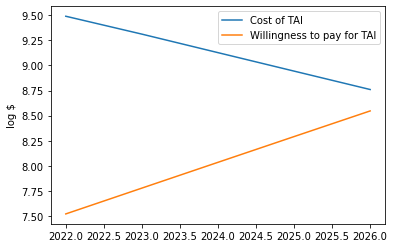

## RUN 24/10000 ##
Diagnostic: tai_flop_size=42.84090931235667, nonscaling_delay=2.817135075381191, algo_doubling_rate=1.5333128283315782, possible_algo_reduction=4.834595475651627, initial_flops_per_dollar=9.151518814740067e+16, flops_halving_rate=3.6667223896537786, max_flops_per_dollar=2.0531613141940397e+24, initial_pay=13344049.447710903, gdp_growth=1.0277333583158133, max_gdp_frac=0.014867067764042084, willingness_ramp=0.8405591891034513, spend_doubling_time=0.9005611815958687
-
It takes 42.8 log FLOPs (one billion decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 4.8 log reductions possible.
FLOPs start at a cost of 17.0 log FLOPs (10 quadrillion) per $. Every 3.7 years they get 2x cheaper, to a maximum of 24.3 log FLOPs (one septillion) per $.
We are willing to pay 7.1 log $ (10 million) and this increases by 0.9x per year to a max of 0.0149% of GDP. GDP grows at a rate of 1.028x per year.
If we are 84.0% of the way to paying for TAI, we

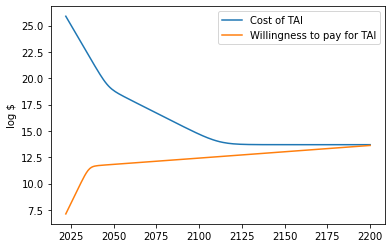

## RUN 25/10000 ##
Diagnostic: tai_flop_size=34.113890373042395, nonscaling_delay=1.1650207865471274, algo_doubling_rate=3.2172648843462355, possible_algo_reduction=2.3348653164068383, initial_flops_per_dollar=1.70268267143881e+17, flops_halving_rate=2.314258087703642, max_flops_per_dollar=8.994501357050947e+23, initial_pay=23637200.160397638, gdp_growth=1.0233652277997498, max_gdp_frac=0.008950763062444, willingness_ramp=1.0009045443651585, spend_doubling_time=0.589309521881929
-
It takes 34.1 log FLOPs (10 decillion) for transformative capabilities.
Every 3.2 years algorithms get 2x better, with 2.3 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 2.3 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (100 sextillion) per $.
We are willing to pay 7.4 log $ (10 million) and this increases by 0.6x per year to a max of 0.009% of GDP. GDP grows at a rate of 1.023x per year.
If we are 100.0% of the way to paying for TAI, we will ramp t

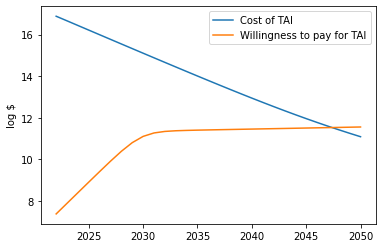

## RUN 26/10000 ##
Diagnostic: tai_flop_size=33.476254906583996, nonscaling_delay=23.403728525122098, algo_doubling_rate=3.4151187586939016, possible_algo_reduction=2.630204949423549, initial_flops_per_dollar=1.7973013918975027e+17, flops_halving_rate=2.7866032634216933, max_flops_per_dollar=2.035429642426425e+25, initial_pay=47329774.05593025, gdp_growth=1.0201660871859086, max_gdp_frac=0.0015, willingness_ramp=0.959508579673062, spend_doubling_time=0.8841596235150957
-
It takes 33.5 log FLOPs (one decillion) for transformative capabilities.
Every 3.4 years algorithms get 2x better, with 2.6 log reductions possible.
FLOPs start at a cost of 17.3 log FLOPs (100 quadrillion) per $. Every 2.8 years they get 2x cheaper, to a maximum of 25.3 log FLOPs (10 septillion) per $.
We are willing to pay 7.7 log $ (10 million) and this increases by 0.9x per year to a max of 0.0015% of GDP. GDP grows at a rate of 1.02x per year.
If we are 96.0% of the way to paying for TAI, we will ramp to paying fo

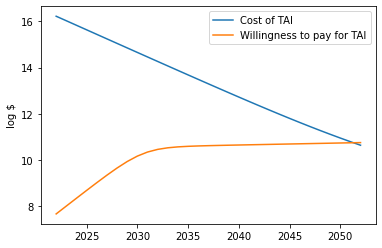

## RUN 27/10000 ##
Diagnostic: tai_flop_size=29.460377719335327, nonscaling_delay=11.603017981772288, algo_doubling_rate=4.383050001370697, possible_algo_reduction=2.33833891326443, initial_flops_per_dollar=3.204602897920576e+17, flops_halving_rate=2.1338590500276378, max_flops_per_dollar=1.0066663027285347e+26, initial_pay=21188044.389712926, gdp_growth=1.023008008230621, max_gdp_frac=0.006578754476007575, willingness_ramp=0.8985585975375912, spend_doubling_time=1.1722051193320915
-
It takes 29.5 log FLOPs (100 octillion) for transformative capabilities.
Every 4.4 years algorithms get 2x better, with 2.3 log reductions possible.
FLOPs start at a cost of 17.5 log FLOPs (100 quadrillion) per $. Every 2.1 years they get 2x cheaper, to a maximum of 26.0 log FLOPs (100 septillion) per $.
We are willing to pay 7.3 log $ (10 million) and this increases by 1.2x per year to a max of 0.0066% of GDP. GDP grows at a rate of 1.023x per year.
If we are 90.0% of the way to paying for TAI, we will ra

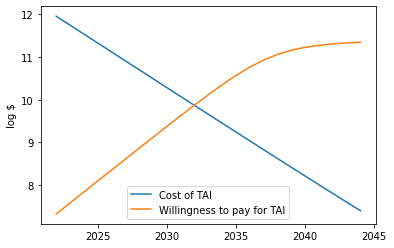

## RUN 28/10000 ##
Diagnostic: tai_flop_size=22.34288888479315, nonscaling_delay=5.4139657551367595, algo_doubling_rate=5.045011763117008, possible_algo_reduction=2.3276289428832264, initial_flops_per_dollar=2.2503081570474992e+17, flops_halving_rate=3.518793499385768, max_flops_per_dollar=1.495357234980996e+25, initial_pay=19863245.160906024, gdp_growth=1.0177546152706134, max_gdp_frac=0.00641884045042832, willingness_ramp=0.8886428275080068, spend_doubling_time=0.5833841328658218
-
It takes 22.3 log FLOPs (10 sextillion) for transformative capabilities.
Every 5.0 years algorithms get 2x better, with 2.3 log reductions possible.
FLOPs start at a cost of 17.4 log FLOPs (100 quadrillion) per $. Every 3.5 years they get 2x cheaper, to a maximum of 25.2 log FLOPs (10 septillion) per $.
We are willing to pay 7.3 log $ (10 million) and this increases by 0.6x per year to a max of 0.0064% of GDP. GDP grows at a rate of 1.018x per year.
If we are 89.0% of the way to paying for TAI, we will ram

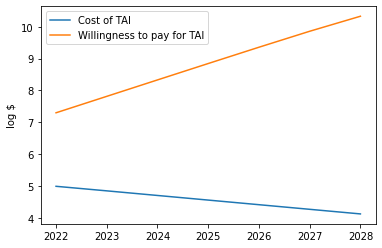

## RUN 29/10000 ##
Diagnostic: tai_flop_size=35.1637462365648, nonscaling_delay=2.8767290395859577, algo_doubling_rate=3.156411496163168, possible_algo_reduction=3.75478599796244, initial_flops_per_dollar=1.465940599969663e+17, flops_halving_rate=2.4146220679005226, max_flops_per_dollar=1.212242049476793e+25, initial_pay=29290146.82183725, gdp_growth=1.0203167244249556, max_gdp_frac=0.025170061965436707, willingness_ramp=0.8844328263854917, spend_doubling_time=0.9658713197534973
-
It takes 35.2 log FLOPs (100 decillion) for transformative capabilities.
Every 3.2 years algorithms get 2x better, with 3.8 log reductions possible.
FLOPs start at a cost of 17.2 log FLOPs (100 quadrillion) per $. Every 2.4 years they get 2x cheaper, to a maximum of 25.1 log FLOPs (10 septillion) per $.
We are willing to pay 7.5 log $ (10 million) and this increases by 1.0x per year to a max of 0.0252% of GDP. GDP grows at a rate of 1.02x per year.
If we are 88.0% of the way to paying for TAI, we will ramp to

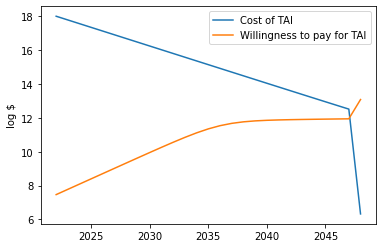

## RUN 30/10000 ##
Diagnostic: tai_flop_size=39.70480882812587, nonscaling_delay=9.985708382128813, algo_doubling_rate=3.868091907980208, possible_algo_reduction=5.379291041005962, initial_flops_per_dollar=1.2621334108026518e+17, flops_halving_rate=1.6950181549765697, max_flops_per_dollar=2.622445236132159e+25, initial_pay=15723661.681844229, gdp_growth=1.0236140272080252, max_gdp_frac=0.004178440567172594, willingness_ramp=0.8394723980186481, spend_doubling_time=1.684497788387676
-
It takes 39.7 log FLOPs (one million decillion) for transformative capabilities.
Every 3.9 years algorithms get 2x better, with 5.4 log reductions possible.
FLOPs start at a cost of 17.1 log FLOPs (100 quadrillion) per $. Every 1.7 years they get 2x cheaper, to a maximum of 25.4 log FLOPs (10 septillion) per $.
We are willing to pay 7.2 log $ (10 million) and this increases by 1.7x per year to a max of 0.0042% of GDP. GDP grows at a rate of 1.024x per year.
If we are 84.0% of the way to paying for TAI, we w

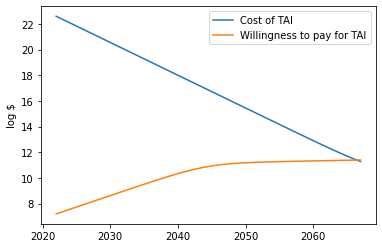

## RUN 101/10000 ##
## RUN 201/10000 ##
## RUN 301/10000 ##
## RUN 401/10000 ##
## RUN 501/10000 ##
## RUN 601/10000 ##
## RUN 701/10000 ##
## RUN 801/10000 ##
## RUN 901/10000 ##
## RUN 1001/10000 ##
## RUN 1101/10000 ##
## RUN 1201/10000 ##
## RUN 1301/10000 ##
## RUN 1401/10000 ##
## RUN 1501/10000 ##
## RUN 1601/10000 ##
## RUN 1701/10000 ##
## RUN 1801/10000 ##
## RUN 1901/10000 ##
## RUN 2001/10000 ##
## RUN 2101/10000 ##
## RUN 2201/10000 ##
## RUN 2301/10000 ##
## RUN 2401/10000 ##
## RUN 2501/10000 ##
## RUN 2601/10000 ##
## RUN 2701/10000 ##
## RUN 2801/10000 ##
## RUN 2901/10000 ##
## RUN 3001/10000 ##
## RUN 3101/10000 ##
## RUN 3201/10000 ##
## RUN 3301/10000 ##
## RUN 3401/10000 ##
## RUN 3501/10000 ##
## RUN 3601/10000 ##
## RUN 3701/10000 ##
## RUN 3801/10000 ##
## RUN 3901/10000 ##
## RUN 4001/10000 ##
## RUN 4101/10000 ##
## RUN 4201/10000 ##
## RUN 4301/10000 ##
## RUN 4401/10000 ##
## RUN 4501/10000 ##
## RUN 4601/10000 ##
## RUN 4701/10000 ##
## RUN 4801/10000 ##
#

In [213]:
tai_years = []
tai_flop_size_log_ = []
plt.ioff()
print('Running')

for r in range(RUNS):
    print_diagnostic = r < 30
    if print_diagnostic or r % 100 == 0 or r >= RUNS - 1:
        print('## RUN {}/{} ##'.format(r + 1, RUNS))
    if print_diagnostic:
        cost_of_tai_collector = []
        willingness_collector = []
    
    tai_flop_size_ = sample(tai_flop_size, credibility=CREDIBLE_INTERVAL)  # TODO: DRY out `, credibility=CREDIBLE_INTERVAL`
    tai_flop_size_log_.append(tai_flop_size_)
    algo_doubling_rate_ = sample(algo_doubling_rate, credibility=CREDIBLE_INTERVAL)
    possible_algo_reduction_ = possible_algo_reduction_fn(sample(min_reduction, credibility=CREDIBLE_INTERVAL),
                                                          sample(max_reduction, credibility=CREDIBLE_INTERVAL),
                                                          tai_flop_size_)
    initial_flops_per_dollar_ = 10 ** sample(initial_flops_per_dollar, credibility=CREDIBLE_INTERVAL)
    flops_halving_rate_ = sample(flops_halving_rate, credibility=CREDIBLE_INTERVAL)
    max_flops_per_dollar_ = 10 ** sample(max_flops_per_dollar, credibility=CREDIBLE_INTERVAL)
    initial_pay_ = 10 ** sample(initial_pay, credibility=CREDIBLE_INTERVAL)
    gdp_growth_ = sample(gdp_growth, credibility=CREDIBLE_INTERVAL)
    max_gdp_frac_ = sample(max_gdp_frac, credibility=CREDIBLE_INTERVAL)
    willingness_ramp_ = sample(willingness_ramp, credibility=CREDIBLE_INTERVAL)
    spend_doubling_time_ = sample(spend_doubling_time, credibility=CREDIBLE_INTERVAL)
    nonscaling_delay_ = sample(nonscaling_delay, credibility=CREDIBLE_INTERVAL)
    initial_chance_of_nonscaling_issue_ = initial_chance_of_nonscaling_issue
    final_chance_of_nonscaling_issue_ = final_chance_of_nonscaling_issue
    
    if print_diagnostic:
        diagnostic = 'Diagnostic: tai_flop_size={}, nonscaling_delay={}, algo_doubling_rate={}, '
        diagnostic += 'possible_algo_reduction={}, initial_flops_per_dollar={}, flops_halving_rate={}, '
        diagnostic += 'max_flops_per_dollar={}, initial_pay={}, gdp_growth={}, max_gdp_frac={}, '
        diagnostic += 'willingness_ramp={}, spend_doubling_time={}'
        print(diagnostic.format(tai_flop_size_, nonscaling_delay_, algo_doubling_rate_,
                                possible_algo_reduction_, initial_flops_per_dollar_, flops_halving_rate_,
                                max_flops_per_dollar_, initial_pay_, gdp_growth_, max_gdp_frac_,
                                willingness_ramp_, spend_doubling_time_))
        # TODO: add other recursive variables
        print('-')

        print('It takes {} log FLOPs ({}) for transformative capabilities.'.format(np.round(tai_flop_size_, 1),
                                                                                   numerize(tai_flop_size_)))
        print('Every {} years algorithms get 2x better, with {} log reductions possible.'.format(np.round(algo_doubling_rate_, 1),
                                                                                                 np.round(possible_algo_reduction_, 1)))
        print(('FLOPs start at a cost of {} log FLOPs ({}) per $. Every {} years they get ' +
               '2x cheaper, to a maximum of {} log FLOPs ({}) per $.').format(np.round(math.log10(initial_flops_per_dollar_), 1),
                                                                              numerize(math.log10(initial_flops_per_dollar_)),
                                                                              np.round(flops_halving_rate_, 1),
                                                                              np.round(math.log10(max_flops_per_dollar_), 1),
                                                                              numerize(math.log10(max_flops_per_dollar_))))
        print(('We are willing to pay {} log $ ({}) and this increases by {}x per year to a max of {}% of GDP. ' +
               'GDP grows at a rate of {}x per year.').format(np.round(math.log10(initial_pay_), 1),
                                                              numerize(math.log10(initial_pay_)),
                                                              np.round(spend_doubling_time_, 1),
                                                              np.round(max_gdp_frac_, 4),
                                                              np.round(gdp_growth_, 3)))
        print('If we are {}% of the way to paying for TAI, we will ramp to paying for TAI.'.format(np.round(willingness_ramp_ * 100)))
        print(('If a non-scaling delay happens, it will take an additional {} years to produce TAI due' +
               ' to issues unrelated to scaling FLOP').format(np.round(nonscaling_delay_, 1)))
        print('---')
    
    tai_created = False
    is_nonscaling_issue = None
    recursive = False
    for y in years:
        if not tai_created:  
            flops_needed_ = flops_needed(initial_flops=10 ** tai_flop_size_,
                                         doubling_rate=algo_doubling_rate_,
                                         possible_reduction=10 ** possible_algo_reduction_,
                                         year=(y - CURRENT_YEAR))
            flops_per_dollar_ = flops_per_dollar(initial_flops_per_dollar=initial_flops_per_dollar_,
                                                 max_flops_per_dollar=max_flops_per_dollar_,
                                                 halving_rate=flops_halving_rate_,
                                                 year=(y - CURRENT_YEAR))
            
            if flops_per_dollar_ > 10 ** 200:
                flops_needed_ = int(flops_needed_)
                flops_per_dollar_ = int(flops_per_dollar_)
                
            cost_of_tai_ = flops_needed_ / flops_per_dollar_
            willingness_ = willingness_to_pay(initial_gdp=initial_gdp,
                                              gdp_growth=gdp_growth_,
                                              initial_pay=initial_pay_,
                                              spend_doubling_time=spend_doubling_time_,
                                              max_gdp_frac=max_gdp_frac_,
                                              year=(y - CURRENT_YEAR))
            
            if flops_per_dollar_ > 10 ** 200:
                willingness_ = int(willingness_)
            if willingness_ > 10 ** 200:
                flops_per_dollar_ = int(flops_per_dollar_)
            
            total_compute_ = willingness_ * flops_per_dollar_
            p_recursive = p_rapid_recursive_self_improvement(flops_needed_,
                                                             total_compute_,
                                                             base_p_recursive,
                                                             recursive_curve_steepness,
                                                             recursive_curve_inflection)
            p_recursive = p_recursive / 8 # Attempt to turn CDF into PDF (approximation)
            
            cost_of_tai_collector.append(cost_of_tai_)
            willingness_collector.append(willingness_)
            
            if print_diagnostic:
                out_str = ('Year: {} - {} max log FLOP ({}) available - TAI takes {} log FLOP ({}) - ' +
                           'log $ {} to buy TAI ({}) vs. willingness to pay log $ {} ({}) - {} log FLOPS per $ ({})')
                print(out_str.format(y,
                                     np.round(math.log10(total_compute_), 1),
                                     numerize(math.log10(total_compute_)),
                                     np.round(math.log10(flops_needed_), 1),
                                     numerize(math.log10(flops_needed_)),
                                     np.round(math.log10(cost_of_tai_), 1),
                                     numerize(math.log10(cost_of_tai_)),
                                     np.round(math.log10(willingness_), 1),
                                     numerize(math.log10(willingness_)),
                                     np.round(math.log10(flops_per_dollar_), 1),
                                     numerize(math.log10(flops_per_dollar_))))
            
            if cost_of_tai_ * willingness_ramp_ <= willingness_:
                if is_nonscaling_issue is None:
                    p_nonscaling_delay_ = p_nonscaling_delay(initial_chance_of_nonscaling_issue,
                                                             final_chance_of_nonscaling_issue,
                                                             year=y,
                                                             max_year=nonscaling_issue_bottom_year)
                    r_ = random.random()
                    is_nonscaling_issue = r_ < p_nonscaling_delay_
                    nonscaling_countdown = nonscaling_delay_
                    if print_diagnostic:
                        print('-- {} p_nonscaling_issue={} r_={}'.format('Nonscaling delay occured' if is_nonscaling_issue else 'Nonscaling issue did not occur',
                                                                         np.round(p_nonscaling_delay_, 4),
                                                                         np.round(r_, 4)))
                
                if not is_nonscaling_issue or nonscaling_countdown <= 0.1:
                    if print_diagnostic:
                        print('--- /!\ TAI CREATED in {}'.format(y))
                        plot_tai(plt, years, cost_of_tai_collector, willingness_collector).show()
                    tai_years.append(y)
                    tai_created = True
                else:
                    if print_diagnostic:
                        print('/!\ FLOPs for TAI sufficient but needs {} more years to solve non-scaling issues'.format(np.round(nonscaling_countdown, 1)))
                    nonscaling_countdown -= 1
            
            r_ = random.random()
            if not tai_created and not is_nonscaling_issue and not recursive and r_ < p_recursive:
                flops_halving_rate__ = sample(recursive_flops_halving_rate, credibility=CREDIBLE_INTERVAL)
                flops_halving_rate_ = flops_halving_rate__ if flops_halving_rate__ < flops_halving_rate_ else flops_halving_rate_
                algo_doubling_rate__ = sample(recursive_algo_doubling_rate, credibility=CREDIBLE_INTERVAL)
                algo_doubling_rate_ = algo_doubling_rate__ if algo_doubling_rate__ < algo_doubling_rate_ else algo_doubling_rate_
                spend_doubling_time__ = sample(recursive_spend_doubling_time, credibility=CREDIBLE_INTERVAL)
                spend_doubling_time_ = spend_doubling_time__ if spend_doubling_time__ < spend_doubling_time_ else spend_doubling_time_
                gdp_growth__ = sample(recursive_gdp_growth, credibility=CREDIBLE_INTERVAL)
                gdp_growth_ = gdp_growth__ if gdp_growth__ > gdp_growth_ else gdp_growth_
                initial_chance_of_nonscaling_issue_ = recursive_initial_chance_of_nonscaling_issue
                final_chance_of_nonscaling_issue_ = recursive_final_chance_of_nonscaling_issue
                recursive = True
                # TODO: fix issue where this changes the variables as of 2022 rather than as of the time of the rapid recursion

                if print_diagnostic:
                    print(('--- rapid recursive loop (p={}, r_={}) - set flops_having_rate={}, algo_doubling_rate={} ' +
                           'spend_doubling_time={}, gdp_growth={}, initial_chance_of_nonscaling_issue={} ' +
                           'final_chance_of_nonscaling_issue={}').format(p_recursive,
                                                                         r_,
                                                                         flops_halving_rate_,
                                                                         algo_doubling_rate_,
                                                                         spend_doubling_time_,
                                                                         gdp_growth_,
                                                                         initial_chance_of_nonscaling_issue,
                                                                         final_chance_of_nonscaling_issue))
                if event_occurs(p_recursive_creates_tai_instantly):
                    if print_diagnostic:
                        print('--- /!\ RRSI LOOP CREATES TAI in {}'.format(y))
                        plot_tai(plt, years, cost_of_tai_collector, willingness_collector).show()
                    tai_years.append(y)
                    tai_created = True
                        
            elif not tai_created and not is_nonscaling_issue and not recursive and print_diagnostic:
                print('--- no rapid recursive loop (p={}, r_={})'.format(p_recursive, r_))
                
    if not tai_created:
        if print_diagnostic:
            print('--- :/ TAI NOT CREATED BEFORE {}'.format(MAX_YEAR + 1))
            plot_tai(plt, years, cost_of_tai_collector, willingness_collector).show()
        tai_years.append(MAX_YEAR + 1)


In [214]:
out = get_percentiles(tai_years)
[str(o[0]) + '%: ' + (str(int(o[1])) if o[1] < MAX_YEAR else '>' + str(MAX_YEAR)) for o in out.items()]

# NOTE: Ajeya's numbers should output something very close to:
# '5%': 2027,
# '10%: 2031',
# '20%: 2037',
# '30%: 2042',
# '40%: 2047',
# '50%: 2053',
# '60%: 2061',
# '70%: 2073',
# '80%: >2100',
# '90%: >2100',
# '95%: >2100'

# My latest numbers (2022 Jul 21 11:28PM CT):
#['5%: 2028',
# '10%: 2031',
# '20%: 2037',
# '30%: 2042',
# '40%: 2049',
# '50%: 2056',
# '60%: 2064',
# '70%: 2075',
# '80%: 2091',
# '90%: 2159',
# '95%: >2222']


['5%: 2028',
 '10%: 2031',
 '20%: 2037',
 '30%: 2042',
 '40%: 2049',
 '50%: 2056',
 '60%: 2064',
 '70%: 2075',
 '80%: 2091',
 '90%: 2159',
 '95%: >2222']

In [215]:
[str(o[0]) + '%: ' + (str(int(o[1]) - CURRENT_YEAR) if o[1] < MAX_YEAR else '>' + str(MAX_YEAR - CURRENT_YEAR)) + ' years from now' for o in out.items()]


['5%: 6 years from now',
 '10%: 9 years from now',
 '20%: 15 years from now',
 '30%: 20 years from now',
 '40%: 27 years from now',
 '50%: 34 years from now',
 '60%: 42 years from now',
 '70%: 53 years from now',
 '80%: 69 years from now',
 '90%: 137 years from now',
 '95%: >200 years from now']

In [216]:
def print_chance_tai_by_year(data, year_target):
    return '{}% chance of TAI by EOY {}'.format(int(np.round(sum([1 if y <= year_target else 0 for y in data]) / len(data) * 100, 0)),
                                                year_target)
    
print('## Within <2 years')
print_chance_tai_by_year(tai_years, 2023)


## Within <2 years


'1% chance of TAI by EOY 2023'

In [217]:
print_chance_tai_by_year(tai_years, 2024)

'1% chance of TAI by EOY 2024'

In [218]:
print_chance_tai_by_year(tai_years, 2025)

'2% chance of TAI by EOY 2025'

In [219]:
print('## Within 5 years')
print_chance_tai_by_year(tai_years, 2027)

## Within 5 years


'4% chance of TAI by EOY 2027'

In [220]:
print_chance_tai_by_year(tai_years, 2029)

'7% chance of TAI by EOY 2029'

In [221]:
print_chance_tai_by_year(tai_years, 2030)

'8% chance of TAI by EOY 2030'

In [222]:
print('## Within 10 years')
print_chance_tai_by_year(tai_years, 2032)

## Within 10 years


'12% chance of TAI by EOY 2032'

In [223]:
# Holden benchmarks from https://www.cold-takes.com/biological-anchors-is-about-bounding-not-pinpointing-ai-timelines/#bio-anchors-as-a-way-of-bounding-ai-timelines
print('## Within 14 years (Holden benchmark - 10%-50%, Holden: 10%)')
print_chance_tai_by_year(tai_years, 2036)


## Within 14 years (Holden benchmark - 10%-50%, Holden: 10%)


'20% chance of TAI by EOY 2036'

In [224]:
print('## Within 15 years')
print_chance_tai_by_year(tai_years, 2037)

## Within 15 years


'21% chance of TAI by EOY 2037'

In [225]:
print_chance_tai_by_year(tai_years, 2039)

'25% chance of TAI by EOY 2039'

In [226]:
print('## Within 20 years')
print_chance_tai_by_year(tai_years, 2042)

## Within 20 years


'30% chance of TAI by EOY 2042'

In [227]:
print('## Within 25 years')
print_chance_tai_by_year(tai_years, 2047)

## Within 25 years


'38% chance of TAI by EOY 2047'

In [228]:
print_chance_tai_by_year(tai_years, 2049)

'41% chance of TAI by EOY 2049'

In [229]:
print_chance_tai_by_year(tai_years, 2059)

'55% chance of TAI by EOY 2059'

In [230]:
print('## Within 38 years (Holden benchmark - 25%-75%, Holden: 50%)')
print_chance_tai_by_year(tai_years, 2060)

## Within 38 years (Holden benchmark - 25%-75%, Holden: 50%)


'56% chance of TAI by EOY 2060'

In [231]:
print_chance_tai_by_year(tai_years, 2069)

'65% chance of TAI by EOY 2069'

In [232]:
print('## Within 48 years (Carlsmith benchmark - Carlsmith: 50%)')
print_chance_tai_by_year(tai_years, 2070)

## Within 48 years (Carlsmith benchmark - Carlsmith: 50%)


'66% chance of TAI by EOY 2070'

In [233]:
print('## Within 50 years')
print_chance_tai_by_year(tai_years, 2072)

## Within 50 years


'68% chance of TAI by EOY 2072'

In [234]:
print('## Within my personal expected lifespan')
print_chance_tai_by_year(tai_years, 2078)

## Within my personal expected lifespan


'72% chance of TAI by EOY 2078'

In [235]:
print('## Within 75 years')
print_chance_tai_by_year(tai_years, 2097)

## Within 75 years


'82% chance of TAI by EOY 2097'

In [236]:
print('## Within 78 years (Holden benchmark - 33%-90%, Holden: 66%)')
print_chance_tai_by_year(tai_years, 2100)

## Within 78 years (Holden benchmark - 33%-90%, Holden: 66%)


'83% chance of TAI by EOY 2100'

In [237]:
print('## Within 100 years')
print_chance_tai_by_year(tai_years, 2122)

## Within 100 years


'87% chance of TAI by EOY 2122'

In [238]:
print('## Within 200 years')
print_chance_tai_by_year(tai_years, 2222)

## Within 200 years


'92% chance of TAI by EOY 2222'

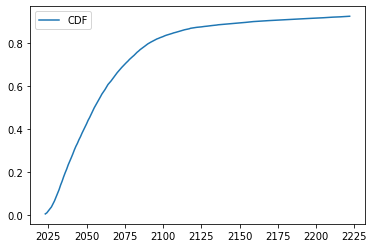

In [239]:
tai_years_ = np.array([MAX_YEAR + 1 if t > MAX_YEAR else t for t in tai_years])
count, bins_count = np.histogram(tai_years_, bins=(MAX_YEAR - CURRENT_YEAR))
pdf = count / sum(count)
cdf = np.cumsum(pdf)
bins = np.round(np.array([b for b in bins_count[1:] if b <= MAX_YEAR]))

plt.plot(bins, cdf[:len(bins)], label='CDF')
plt.legend()

<string>:192: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<string>:193: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#d

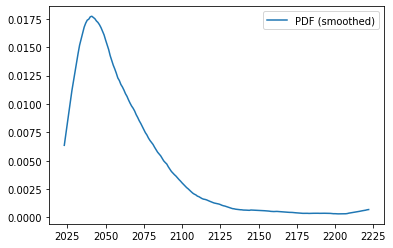

In [240]:
pdf_smoothed = savitzky_golay(pdf[:len(bins)], 51, 3) # window size 51, polynomial order 3
plt.plot(bins, pdf_smoothed, label='PDF (smoothed)')
plt.legend()
plt.show()

In [241]:
cdf[:len(bins)]

array([0.0065, 0.0114, 0.0202, 0.0297, 0.0387, 0.0523, 0.0667, 0.0845,
       0.1022, 0.119 , 0.1403, 0.1584, 0.179 , 0.1977, 0.2148, 0.2347,
       0.251 , 0.2677, 0.285 , 0.3037, 0.3203, 0.3343, 0.351 , 0.365 ,
       0.3814, 0.3959, 0.4112, 0.4251, 0.4413, 0.4543, 0.469 , 0.4848,
       0.4993, 0.5118, 0.524 , 0.5363, 0.5497, 0.5629, 0.5734, 0.5835,
       0.5959, 0.6075, 0.6154, 0.6239, 0.6335, 0.6431, 0.6529, 0.6623,
       0.6707, 0.6789, 0.6869, 0.6944, 0.7018, 0.7091, 0.7158, 0.7236,
       0.7302, 0.7365, 0.7426, 0.7496, 0.757 , 0.7627, 0.7693, 0.7744,
       0.7798, 0.7851, 0.7908, 0.7959, 0.8002, 0.8042, 0.808 , 0.8117,
       0.8152, 0.8191, 0.8216, 0.8248, 0.8272, 0.83  , 0.8333, 0.836 ,
       0.8381, 0.8403, 0.8428, 0.8447, 0.8473, 0.849 , 0.8513, 0.8531,
       0.8552, 0.8574, 0.8593, 0.8615, 0.863 , 0.8649, 0.866 , 0.8685,
       0.8696, 0.8709, 0.8717, 0.8729, 0.8742, 0.875 , 0.8762, 0.877 ,
       0.8776, 0.8785, 0.8795, 0.8805, 0.8812, 0.8818, 0.8826, 0.8835,
      

In [242]:
pdf[:len(bins)]

array([0.0065, 0.0049, 0.0088, 0.0095, 0.009 , 0.0136, 0.0144, 0.0178,
       0.0177, 0.0168, 0.0213, 0.0181, 0.0206, 0.0187, 0.0171, 0.0199,
       0.0163, 0.0167, 0.0173, 0.0187, 0.0166, 0.014 , 0.0167, 0.014 ,
       0.0164, 0.0145, 0.0153, 0.0139, 0.0162, 0.013 , 0.0147, 0.0158,
       0.0145, 0.0125, 0.0122, 0.0123, 0.0134, 0.0132, 0.0105, 0.0101,
       0.0124, 0.0116, 0.0079, 0.0085, 0.0096, 0.0096, 0.0098, 0.0094,
       0.0084, 0.0082, 0.008 , 0.0075, 0.0074, 0.0073, 0.0067, 0.0078,
       0.0066, 0.0063, 0.0061, 0.007 , 0.0074, 0.0057, 0.0066, 0.0051,
       0.0054, 0.0053, 0.0057, 0.0051, 0.0043, 0.004 , 0.0038, 0.0037,
       0.0035, 0.0039, 0.0025, 0.0032, 0.0024, 0.0028, 0.0033, 0.0027,
       0.0021, 0.0022, 0.0025, 0.0019, 0.0026, 0.0017, 0.0023, 0.0018,
       0.0021, 0.0022, 0.0019, 0.0022, 0.0015, 0.0019, 0.0011, 0.0025,
       0.0011, 0.0013, 0.0008, 0.0012, 0.0013, 0.0008, 0.0012, 0.0008,
       0.0006, 0.0009, 0.001 , 0.001 , 0.0007, 0.0006, 0.0008, 0.0009,
      

<string>:192: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<string>:193: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#d

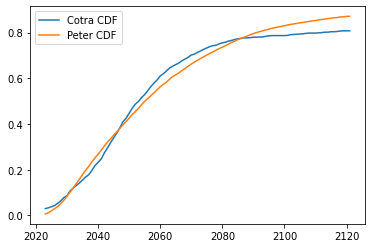

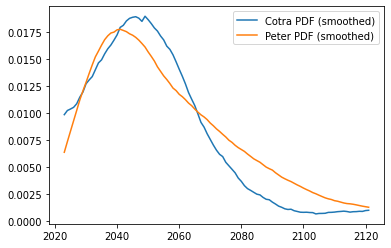

In [244]:
ajeya_cdf = [0.03 , 0.033, 0.038, 0.043, 0.053, 0.064, 0.078, 0.086, 0.107, 0.12 , 0.131, 0.142, 0.155, 0.168, 0.178,
             0.197, 0.218, 0.232, 0.247, 0.273, 0.295, 0.318, 0.339, 0.36 , 0.383, 0.41 , 0.425, 0.447, 0.469, 0.487,
             0.499, 0.516, 0.529, 0.546, 0.564, 0.579, 0.593, 0.61 , 0.62 , 0.632, 0.645, 0.653, 0.66 , 0.667, 0.677,
             0.684, 0.692, 0.702, 0.706, 0.713, 0.72 , 0.727, 0.733, 0.739, 0.743, 0.745, 0.751, 0.755, 0.758, 0.763,
             0.766, 0.77 , 0.773, 0.775, 0.777, 0.777, 0.778, 0.78 , 0.78 , 0.781, 0.781, 0.784, 0.786, 0.787, 0.787,
             0.787, 0.787, 0.787, 0.788, 0.791, 0.792, 0.793, 0.794, 0.795, 0.797, 0.798, 0.798, 0.798, 0.799, 0.8  ,
             0.802, 0.802, 0.804, 0.804, 0.805, 0.807, 0.808, 0.808, 0.808]
ajeya_pdf = np.append(np.array(ajeya_cdf[0]), np.diff(ajeya_cdf[:len(bins)]))
ajeya_pdf_smoothed = savitzky_golay(ajeya_pdf[:len(bins)], 51, 3)

peter_cdf = [0.0065, 0.0114, 0.0202, 0.0297, 0.0387, 0.0523, 0.0667, 0.0845,
       0.1022, 0.119 , 0.1403, 0.1584, 0.179 , 0.1977, 0.2148, 0.2347,
       0.251 , 0.2677, 0.285 , 0.3037, 0.3203, 0.3343, 0.351 , 0.365 ,
       0.3814, 0.3959, 0.4112, 0.4251, 0.4413, 0.4543, 0.469 , 0.4848,
       0.4993, 0.5118, 0.524 , 0.5363, 0.5497, 0.5629, 0.5734, 0.5835,
       0.5959, 0.6075, 0.6154, 0.6239, 0.6335, 0.6431, 0.6529, 0.6623,
       0.6707, 0.6789, 0.6869, 0.6944, 0.7018, 0.7091, 0.7158, 0.7236,
       0.7302, 0.7365, 0.7426, 0.7496, 0.757 , 0.7627, 0.7693, 0.7744,
       0.7798, 0.7851, 0.7908, 0.7959, 0.8002, 0.8042, 0.808 , 0.8117,
       0.8152, 0.8191, 0.8216, 0.8248, 0.8272, 0.83  , 0.8333, 0.836 ,
       0.8381, 0.8403, 0.8428, 0.8447, 0.8473, 0.849 , 0.8513, 0.8531,
       0.8552, 0.8574, 0.8593, 0.8615, 0.863 , 0.8649, 0.866 , 0.8685,
       0.8696, 0.8709, 0.8717, 0.8729, 0.8742, 0.875 , 0.8762, 0.877 ,
       0.8776, 0.8785, 0.8795, 0.8805, 0.8812, 0.8818, 0.8826, 0.8835,
       0.8847, 0.8853, 0.8858, 0.8869, 0.8874, 0.8876, 0.8882, 0.8888,
       0.8896, 0.8904, 0.891 , 0.8916, 0.8922, 0.8925, 0.8932, 0.8938,
       0.8943, 0.895 , 0.8959, 0.8967, 0.8974, 0.898 , 0.899 , 0.8996,
       0.9   , 0.9004, 0.9006, 0.9011, 0.9015, 0.9023, 0.9029, 0.9032,
       0.9039, 0.9041, 0.9045, 0.9048, 0.9052, 0.9057, 0.9061, 0.9064,
       0.9067, 0.907 , 0.9073, 0.9076, 0.908 , 0.9086, 0.9092, 0.91  ,
       0.9102, 0.9106, 0.9107, 0.911 , 0.9114, 0.9117, 0.9123, 0.9128,
       0.913 , 0.9133, 0.9136, 0.914 , 0.9143, 0.9145, 0.9151, 0.9155,
       0.9156, 0.916 , 0.9164, 0.9167, 0.9172, 0.9175, 0.918 , 0.9183,
       0.9189, 0.9195, 0.92  , 0.9202, 0.9204, 0.9206, 0.9208, 0.9212,
       0.9217, 0.9221, 0.9224, 0.9231, 0.9234, 0.9237, 0.9244]
peter_pdf = np.append(np.array(peter_cdf[0]), np.diff(peter_cdf[:len(bins)]))
peter_pdf_smoothed = savitzky_golay(peter_pdf[:len(bins)], 51, 3)

plt.plot(bins[:99], ajeya_cdf[:99], label='Cotra CDF')
plt.plot(bins[:99], peter_cdf[:99], label='Peter CDF')
plt.legend()
plt.show()

plt.plot(bins[:99], ajeya_pdf_smoothed[:99], label='Cotra PDF (smoothed)')
plt.plot(bins[:99], peter_pdf_smoothed[:99], label='Peter PDF (smoothed)')
plt.legend()
plt.show()